# Flight Delay Prediction and Analysis

**Workflow:**
1. Load & Preprocess Data (Handling missing `TAIL_NUM`)
2. EDA Visualization
3. Feature Engineering (Excluding `TAIL_NUM`-dependent features, using `ROUTE_KEY`-based previous delay)
4. Network Analysis (Centrality, Simulation, Validation) - **Performed BEFORE Model Training**
5. Merge Network Features into dataset
6. Model Training & SHAP Analysis
7. Integrated Analysis (Feature Importance vs. Network Centrality, Ablation Study)

# **Research Questions**


*   A: What factors have the greatest impact on predicting individual flight arrival delays (ARR_DELAY)?

*   B: What is the centrality (PageRank, Betweenness) of the airport network, how do delays propagate (simulation/actual), and how does centrality relate to propagation?

*   C: When integrating Feature Importance (A) and Network Centrality (B), what information is most important for delay prediction, and how does model performance change (Ablation)?





In [2]:
"metadata": {
    "widgets": {
        "state": {}
    }
}

SyntaxError: illegal target for annotation (3213735450.py, line 1)

# ⭐When use Google Colab (Check this before run the code)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

# plot_dir =  "/content/drive/MyDrive/Flight_Plots" # <- For Colab
plot_dir = "/Users/jh/Desktop/flightProj/plots"

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import holidays
import shap
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# Scikit-learn libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone

# Model libraries
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# Other utilities
from scipy.stats import spearmanr
from tqdm.notebook import tqdm # Uses ipywidgets
import random
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

# --- Pandas Global Display Option ---
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print("Pandas float display format set globally to '{:.4f}'.")

# --- Create Directory for Saving Plots ---
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    print(f"Directory '{plot_dir}' created for saving plots.")
else:
    print(f"Directory '{plot_dir}' already exists.")

Pandas float display format set globally to '{:.4f}'.
Directory '/Users/jh/Desktop/flightProj/plots' created for saving plots.


# 1: Data Loading and Initial Preprocessing

In [4]:
def load_and_preprocess_data(path, sample_frac=0.3, random_state=42, filter_by_delay_cause=True):
    """Loads data, performs basic preprocessing, handles missing TAIL_NUM, and optionally filters by delay cause."""
    print(f"Starting data loading: {path}")
    use_cols = ['FL_DATE', 'AIRLINE', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME',
                'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'AIR_TIME',
                'DISTANCE', 'FL_NUMBER',
                'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
                'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']
    dtype_spec = {
        'DEP_DELAY': 'float32', 'ARR_DELAY': 'float32', 'AIR_TIME': 'float32',
        'DISTANCE': 'float32', 'FL_NUMBER': 'int32',
        'DELAY_DUE_CARRIER': 'float32', 'DELAY_DUE_WEATHER': 'float32', 'DELAY_DUE_NAS': 'float32',
        'DELAY_DUE_SECURITY': 'float32', 'DELAY_DUE_LATE_AIRCRAFT': 'float32'
    }

    try:
        df = pd.read_csv(path, parse_dates=['FL_DATE'], usecols=use_cols, dtype=dtype_spec)
        print(f"Initial data size: {df.shape}")
    except ValueError as e:
        print(f"Error reading CSV: {e}. Check 'use_cols'.")
        return pd.DataFrame()
    except FileNotFoundError:
        print(f"Error: File not found at {path}")
        return pd.DataFrame()

    # Drop rows with missing essential delay info (TAIL_NUM check removed)
    initial_rows = len(df)
    df.dropna(subset=['ARR_DELAY', 'DEP_DELAY'], inplace=True)
    print(f"Data size after dropping essential NaNs: {df.shape} (Removed {initial_rows - len(df)} rows)")

    # Filtering: Keep only rows with a non-zero delay cause recorded
    if filter_by_delay_cause:
        delay_cause_cols = ['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
                            'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']
        existing_delay_cause_cols = [col for col in delay_cause_cols if col in df.columns]
        if existing_delay_cause_cols:
            df_delay_causes = df[existing_delay_cause_cols].fillna(0)
            mask = df_delay_causes.sum(axis=1) > 0
            original_size = df.shape[0]
            df = df[mask]
            print(f"Data size after filtering by delay cause: {df.shape} (Removed {original_size - df.shape[0]} rows)")
            if df.empty:
                print("Warning: Filtering removed all data!")
                return df
        else:
            print("Warning: No DELAY_DUE_* columns found for filtering.")

    # Sampling
    if sample_frac < 1.0 and not df.empty:
        print(f"Sampling {sample_frac*100}% of the data...")
        try:
            if 'AIRLINE' in df.columns and df['AIRLINE'].nunique() > 1:
                _, df = train_test_split(df, test_size=sample_frac, stratify=df['AIRLINE'], random_state=random_state)
            else:
                print("Sampling without stratification (AIRLINE missing or unique).")
                _, df = train_test_split(df, test_size=sample_frac, random_state=random_state)
            print(f"Data size after sampling: {df.shape}")
        except ValueError as e:
            print(f"Stratify failed ({e}). Sampling without stratification.")
            _, df = train_test_split(df, test_size=sample_frac, random_state=random_state)
            print(f"Data size after sampling: {df.shape}")

    # Basic Feature Engineering (Time, Date parts)
    if not df.empty:
        if not pd.api.types.is_datetime64_any_dtype(df['FL_DATE']):
            df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

        df['YEAR'] = df['FL_DATE'].dt.year.astype('int16')
        df['MONTH'] = df['FL_DATE'].dt.month.astype('int8')
        df['WEEKDAY'] = df['FL_DATE'].dt.weekday.astype('int8')
        df['DAY'] = df['FL_DATE'].dt.day.astype('int8')

        # Hour features
        for col in ['DEP_TIME', 'ARR_TIME', 'CRS_DEP_TIME', 'CRS_ARR_TIME']:
            if col in df.columns:
                hour_col_name = col.replace('_TIME', '_HOUR')
                time_str = df[col].fillna(0).astype(str).str.split('.').str[0].str.zfill(4)
                df[hour_col_name] = pd.to_numeric(time_str.str[:2], errors='coerce').fillna(0).astype(int)
                df[hour_col_name] = df[hour_col_name].apply(lambda x: x if 0 <= x <= 23 else 0)

        # Holiday feature
        if 'YEAR' in df.columns:
            unique_years = df['YEAR'].unique()
            if len(unique_years) > 0:
                us_holidays = holidays.US(years=unique_years)
                df['IS_HOLIDAY'] = df['FL_DATE'].dt.date.isin(us_holidays).astype(int)
            else: df['IS_HOLIDAY'] = 0
        else: df['IS_HOLIDAY'] = 0

        # Season feature
        if 'MONTH' in df.columns:
            df['SEASON'] = ((df['MONTH'] % 12 + 3) // 3)
        else: df['SEASON'] = 0

        # Rename raw delay columns (will be excluded from features later)
        df.rename(columns={'ARR_DELAY': 'ARR_DELAY_raw', 'DEP_DELAY': 'DEP_DELAY_raw'}, inplace=True)

        # Memory optimization
        for col in df.select_dtypes(include=['float64']).columns:
            df[col] = df[col].astype('float32')
        for col in df.select_dtypes(include=['int64']).columns:
            if col in df and not df[col].isnull().any(): # Check for NaNs before conversion
                min_val, max_val = df[col].min(), df[col].max()
                if min_val >= 0:
                    if max_val < 255: df[col] = df[col].astype('uint8')
                    elif max_val < 65535: df[col] = df[col].astype('uint16')
                    elif max_val < 4294967295: df[col] = df[col].astype('uint32')
                else:
                    if min_val >= -128 and max_val < 128: df[col] = df[col].astype('int8')
                    elif min_val >= -32768 and max_val < 32768: df[col] = df[col].astype('int16')
                    elif min_val >= -2147483648 and max_val < 2147483648: df[col] = df[col].astype('int32')

    print("Data loading and initial preprocessing complete.")
    return df

# ⭐Check this before run the code

In [28]:
# When use my computer
file_path = "/Users/jh/Desktop/flightProj/data/flights_sample_3m.csv"


## When use Colab
# file_path = ("/content/drive/MyDrive/content/flights_sample_3m.csv")


df = load_and_preprocess_data(file_path, sample_frac=0.5, filter_by_delay_cause=True)

Starting data loading: /Users/jh/Desktop/flightProj/data/flights_sample_3m.csv
Initial data size: (3000000, 18)
Data size after dropping essential NaNs: (2913802, 18) (Removed 86198 rows)
Data size after filtering by delay cause: (533863, 18) (Removed 2379939 rows)
Sampling 50.0% of the data...
Data size after sampling: (266932, 18)
Data loading and initial preprocessing complete.


# 2: EDA Visualizations

--- Starting Exploratory Data Analysis (EDA) ---
Plotting Delay Distributions...


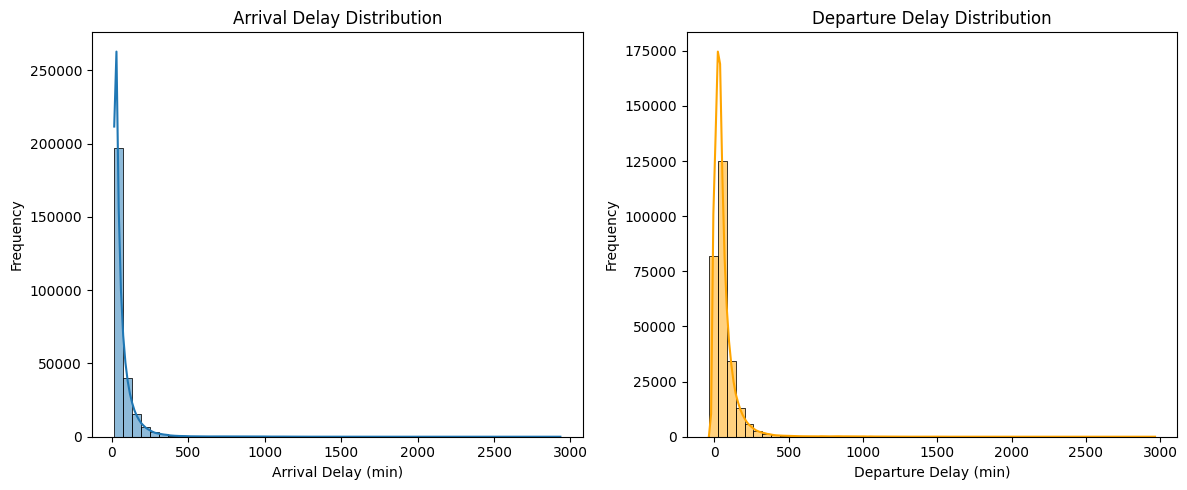

Plotting Departure Delay vs Arrival Delay...


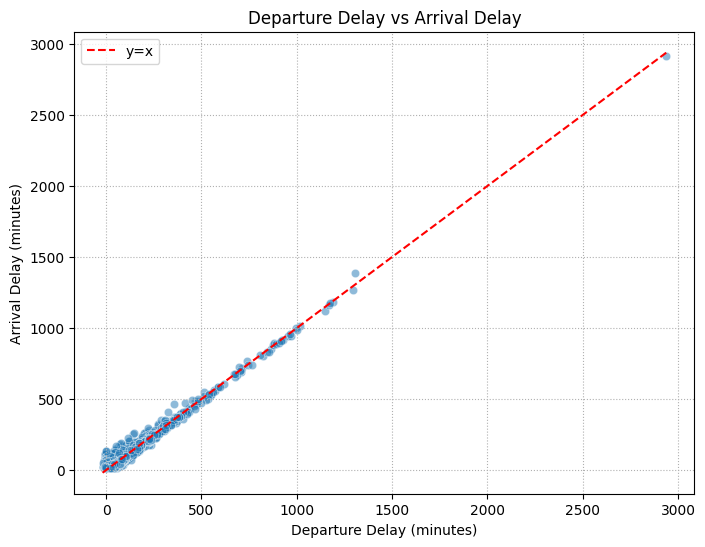

Plotting Average Arrival Delay by Departure Hour...


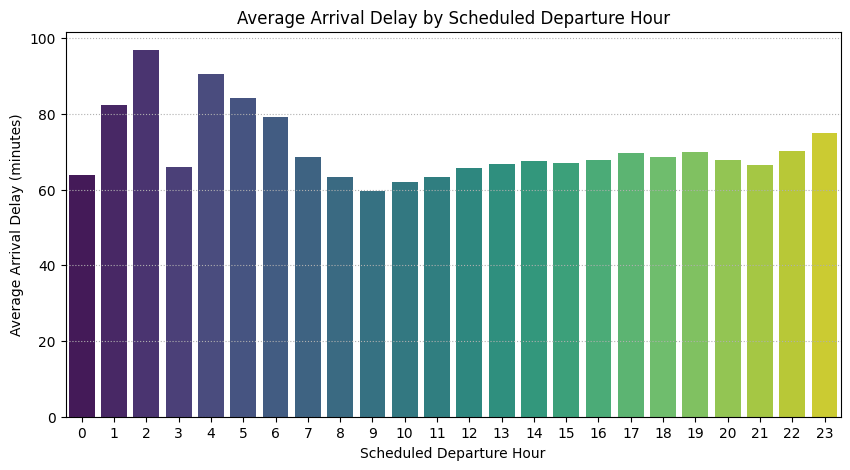

Plotting Average Arrival Delay by Day of Week...


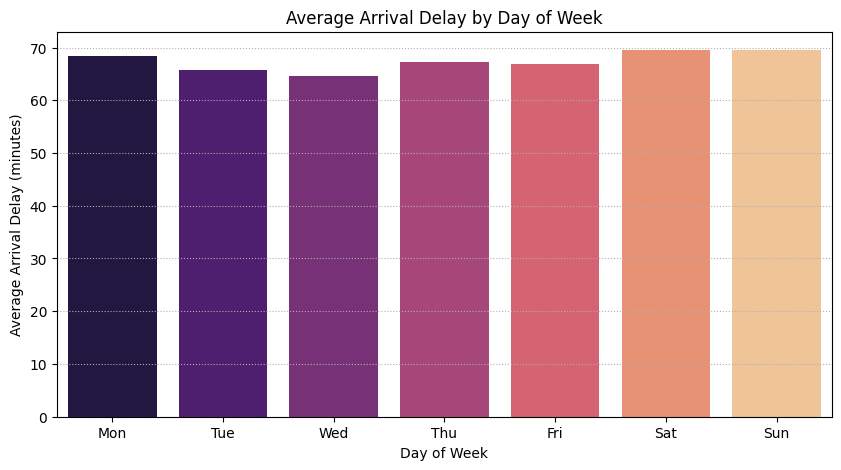

Plotting Flight Counts for Top Airlines...


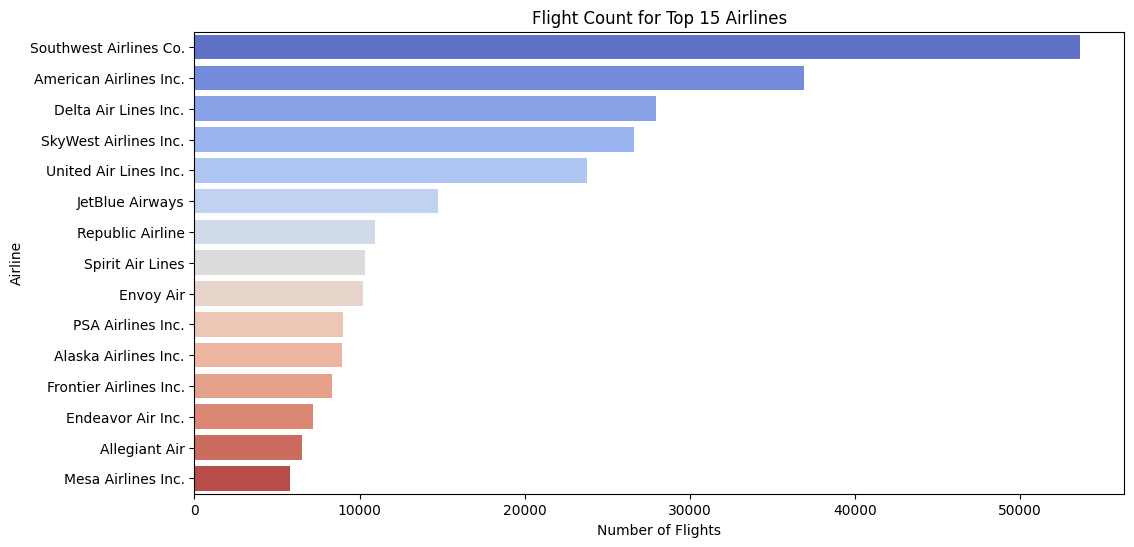

Calculating and plotting correlation heatmap...


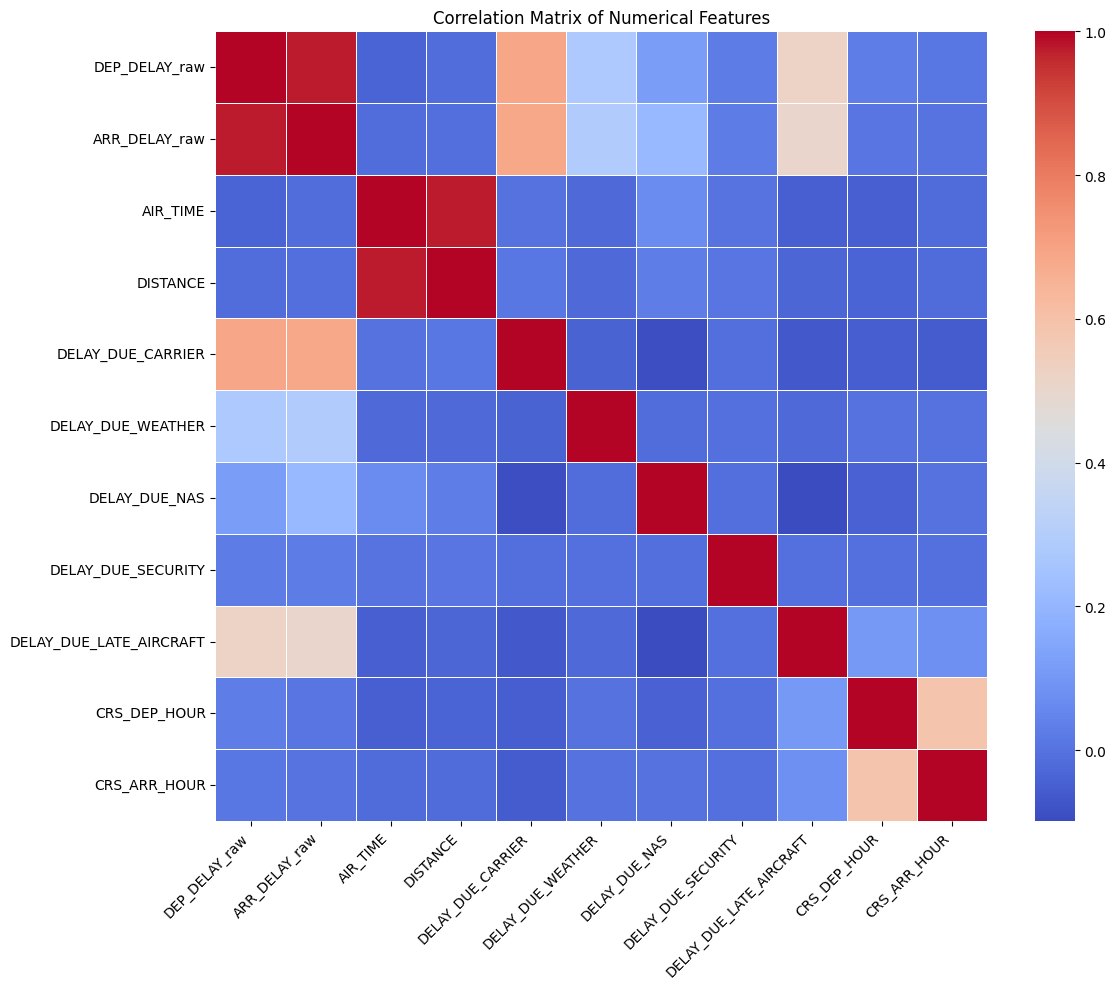

Plotting Heatmap of Flight Frequency by Airline and Hour...


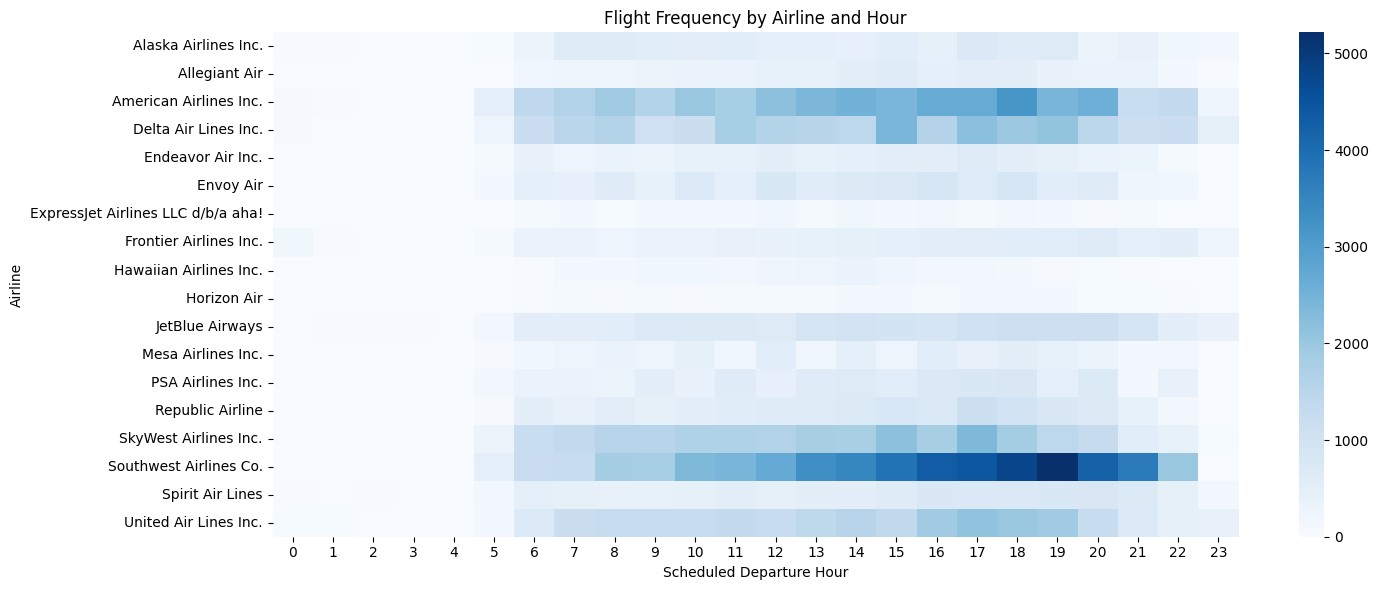

--- EDA Finished ---


In [29]:
print("--- Starting Exploratory Data Analysis (EDA) ---")

# Ensure df exists and is not empty
if 'df' in locals() and not df.empty:

    # 1. Delay Distributions
    print("Plotting Delay Distributions...")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    arr_delay_numeric = pd.to_numeric(df['ARR_DELAY_raw'], errors='coerce').dropna()
    if not arr_delay_numeric.empty: sns.histplot(arr_delay_numeric, kde=True, bins=50)
    plt.title('Arrival Delay Distribution'); plt.xlabel('Arrival Delay (min)'); plt.ylabel('Frequency')
    plt.subplot(1, 2, 2)
    dep_delay_numeric = pd.to_numeric(df['DEP_DELAY_raw'], errors='coerce').dropna()
    if not dep_delay_numeric.empty: sns.histplot(dep_delay_numeric, kde=True, bins=50, color='orange')
    plt.title('Departure Delay Distribution'); plt.xlabel('Departure Delay (min)'); plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'eda_delay_distributions.png'), dpi=150, bbox_inches='tight') # Save plot
    plt.show()

    # 2. Relationship between Departure Delay and Arrival Delay (Scatter Plot)
    print("Plotting Departure Delay vs Arrival Delay...")
    sample_size_scatter = min(5000, len(df)) # Adjust sample size as needed
    df_sample = df.sample(sample_size_scatter, random_state=42)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='DEP_DELAY_raw', y='ARR_DELAY_raw', data=df_sample, alpha=0.5)
    plt.title('Departure Delay vs Arrival Delay')
    plt.xlabel('Departure Delay (minutes)')
    plt.ylabel('Arrival Delay (minutes)')
    plt.grid(True, linestyle=':')
    # Add a line y=x for reference
    # Handle potential NaN values before finding min/max
    dep_delay_valid = df_sample['DEP_DELAY_raw'].dropna()
    arr_delay_valid = df_sample['ARR_DELAY_raw'].dropna()
    if not dep_delay_valid.empty and not arr_delay_valid.empty:
        # Calculate min/max only if both series have valid data
        try:
            max_val = max(dep_delay_valid.max(), arr_delay_valid.max())
            min_val = min(dep_delay_valid.min(), arr_delay_valid.min())
            # Ensure min_val is not greater than max_val
            if min_val <= max_val:
                plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y=x')
                plt.legend()
            else:
                print("Warning: min_val > max_val, cannot plot y=x line.")
        except Exception as e:
            print(f"Warning: Could not calculate min/max for y=x line: {e}")
    else:
        print("Warning: Could not plot y=x line due to missing delay values in sample.")
    plt.savefig(os.path.join(plot_dir, 'eda_dep_vs_arr_delay_scatter.png'), dpi=150, bbox_inches='tight')
    plt.show()

    # 3. Average Arrival Delay by Scheduled Departure Hour (Bar Plot)
    if 'CRS_DEP_HOUR' in df.columns:
        print("Plotting Average Arrival Delay by Departure Hour...")
        plt.figure(figsize=(10, 5))
        # Ensure ARR_DELAY_raw is numeric before grouping
        if pd.api.types.is_numeric_dtype(df['ARR_DELAY_raw']):
            hourly_delay = df.groupby('CRS_DEP_HOUR')['ARR_DELAY_raw'].mean().reset_index()
            sns.barplot(x='CRS_DEP_HOUR', y='ARR_DELAY_raw', data=hourly_delay, palette='viridis')
            plt.title('Average Arrival Delay by Scheduled Departure Hour')
            plt.xlabel('Scheduled Departure Hour')
            plt.ylabel('Average Arrival Delay (minutes)')
            plt.grid(True, axis='y', linestyle=':')
            plt.savefig(os.path.join(plot_dir, 'eda_avg_delay_by_hour.png'), dpi=150, bbox_inches='tight')
            plt.show()
        else:
            print("Skipping hourly delay plot: ARR_DELAY_raw is not numeric.")
    else:
        print("Skipping hourly delay plot: CRS_DEP_HOUR column missing.")

    # 4. Average Arrival Delay by Day of Week (Bar Plot)
    if 'WEEKDAY' in df.columns:
        print("Plotting Average Arrival Delay by Day of Week...")
        plt.figure(figsize=(10, 5))
        # Ensure ARR_DELAY_raw is numeric before grouping
        if pd.api.types.is_numeric_dtype(df['ARR_DELAY_raw']):
            weekday_delay = df.groupby('WEEKDAY')['ARR_DELAY_raw'].mean().reset_index()
            # Map weekday number to name for better readability
            weekday_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
            weekday_delay['WEEKDAY_Name'] = weekday_delay['WEEKDAY'].map(weekday_map)
            # Ensure correct order if mapping worked
            day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
            # Check if all expected names are present after mapping before using order
            if set(weekday_delay['WEEKDAY_Name'].dropna().unique()) == set(day_order):
                sns.barplot(x='WEEKDAY_Name', y='ARR_DELAY_raw', data=weekday_delay, order=day_order, palette='magma')
            else: # Fallback if mapping failed or data is unusual
                print("Warning: Could not map all weekdays, plotting by number.")
                sns.barplot(x='WEEKDAY', y='ARR_DELAY_raw', data=weekday_delay.sort_values('WEEKDAY'), palette='magma')

            plt.title('Average Arrival Delay by Day of Week')
            plt.xlabel('Day of Week')
            plt.ylabel('Average Arrival Delay (minutes)')
            plt.grid(True, axis='y', linestyle=':')
            plt.savefig(os.path.join(plot_dir, 'eda_avg_delay_by_weekday.png'), dpi=150, bbox_inches='tight')
            plt.show()
        else:
            print("Skipping weekday delay plot: ARR_DELAY_raw is not numeric.")
    else:
        print("Skipping weekday delay plot: WEEKDAY column missing.")

    # 5. Flight Counts for Top N Airlines (Count Plot)
    if 'AIRLINE' in df.columns:
        print("Plotting Flight Counts for Top Airlines...")
        top_n_airlines = 15 # Adjust as needed
        plt.figure(figsize=(12, 6))
        # Ensure there are airlines to plot
        if not df['AIRLINE'].empty and df['AIRLINE'].nunique() > 0:
            airline_order = df['AIRLINE'].value_counts().head(top_n_airlines).index
            sns.countplot(y='AIRLINE', data=df, order=airline_order, palette='coolwarm')
            plt.title(f'Flight Count for Top {top_n_airlines} Airlines')
            plt.xlabel('Number of Flights')
            plt.ylabel('Airline')
            plt.savefig(os.path.join(plot_dir, 'eda_flight_counts_by_airline.png'), dpi=150, bbox_inches='tight')
            plt.show()
        else:
            print("Skipping airline count plot: No airline data available.")
    else:
        print("Skipping airline count plot: AIRLINE column missing.")

    # 6. Correlation Heatmap (for numeric features)
    print("Calculating and plotting correlation heatmap...")
    plt.figure(figsize=(12, 10))
    numerical_cols_for_corr = [
        'DEP_DELAY_raw', 'ARR_DELAY_raw', 'AIR_TIME', 'DISTANCE',
        'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
        'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT',
        'CRS_DEP_HOUR', 'CRS_ARR_HOUR'
    ]
    existing_numerical_cols = [col for col in numerical_cols_for_corr if col in df and pd.api.types.is_numeric_dtype(df[col])]
    if len(existing_numerical_cols) > 1:
        corr_matrix = df[existing_numerical_cols].corr()
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Numerical Features')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, 'eda_correlation_heatmap.png'), dpi=150, bbox_inches='tight') # Save plot
        plt.show()
    else:
        print("Skipping heatmap: Not enough numerical columns found.")

    # 7. Heatmap of flight frequency by airline and hour
    print("Plotting Heatmap of Flight Frequency by Airline and Hour...")
    df['hour'] = (df['CRS_DEP_TIME'] // 100).astype('Int64')

    airline_hour_counts = df.groupby(['AIRLINE', 'hour']).size().unstack().fillna(0)

    plt.figure(figsize=(15, 6))
    sns.heatmap(airline_hour_counts, cmap='Blues')
    plt.title('Flight Frequency by Airline and Hour')
    plt.xlabel('Scheduled Departure Hour')
    plt.ylabel('Airline')
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'FlightFrequency_heatmap.png'))
    plt.show()


    print("--- EDA Finished ---")

else:
    print("Skipping EDA: Input DataFrame 'df' is empty or not defined.")



# 3: Feature Engineering

In [30]:
# Conversion + Hub Derivation

def time_to_minutes(time_val):
    """Converts HHMM time format to minutes."""
    try:
        # Handle potential float inputs (e.g., 2359.0)
        s = str(int(float(time_val))).zfill(4)
        if len(s) >= 4: # Check for HHMM format
            return int(s[:2]) * 60 + int(s[2:4])
        elif len(s) >= 1: # Treat as MM (or HMM) -> minutes only
            return int(s)
        else: # Handle unparseable cases
            return 0
    except:
        return 0 # Return 0 if any conversion error occurs

def feature_engineering_extended(df):
    """ Extended feature engineering.
        - Calculates ROUTE_KEY based previous delay (D_a_i_minus1).
        - Derives Hub status based on flight counts per airline.
        - Excludes TAIL_NUM dependent features as TAIL_NUM is unavailable.
    """
    print("Starting extended feature engineering...")
    if df.empty:
        print("Input DataFrame is empty. Skipping feature engineering.")
        return df
    df_eng = df.copy()

    # --- Calculate D_a_i_minus1 based on ROUTE_KEY (proxy for previous delay) ---
    route_key_cols = ['AIRLINE', 'FL_NUMBER', 'ORIGIN', 'FL_DATE', 'CRS_DEP_TIME', 'ARR_DELAY_raw']
    if not all(col in df_eng.columns for col in route_key_cols):
        print(f"Warning: Missing columns required for ROUTE_KEY D_a_i_minus1: {route_key_cols}. Skipping feature.")
        df_eng['D_a_i_minus1'] = 0 # Assign default
    else:
        print("Calculating previous arrival delay (D_a_i_minus1) based on ROUTE_KEY...")
        # Ensure FL_DATE is datetime
        if not pd.api.types.is_datetime64_any_dtype(df_eng['FL_DATE']):
            df_eng['FL_DATE'] = pd.to_datetime(df_eng['FL_DATE'], errors='coerce')
            df_eng.dropna(subset=['FL_DATE'], inplace=True) # Drop if conversion failed

        if not df_eng.empty:
            df_eng['ROUTE_KEY'] = (
                df_eng['AIRLINE'].astype(str) + "_" +
                df_eng['FL_NUMBER'].astype(str) + "_" +
                df_eng['ORIGIN'].astype(str) + "_" +
                df_eng['FL_DATE'].dt.strftime("%Y-%m-%d")
            )
            # Sort by the route and scheduled departure time
            df_eng = df_eng.sort_values(['ROUTE_KEY','CRS_DEP_TIME'])
            # Calculate shifted delay within the route group
            df_eng['D_a_i_minus1'] = (
                df_eng.groupby('ROUTE_KEY')['ARR_DELAY_raw'] # Use the renamed raw delay column
                .shift(1)
                .fillna(0)
            )
            print("D_a_i_minus1 calculation complete.")
        else:
            print("DataFrame became empty after FL_DATE processing. Skipping D_a_i_minus1.")
            df_eng['D_a_i_minus1'] = 0

    # --- Derive Hub status based on flight counts per airline ---
    print("Deriving Hub status based on flight counts per airline...")
    hub_mapping_derived = {}
    try:
        if 'AIRLINE' in df_eng.columns and 'ORIGIN' in df_eng.columns and 'DEST' in df_eng.columns:
            # Calculate total traffic (departures + arrivals) per airline per airport
            origin_counts = df_eng.groupby(['AIRLINE', 'ORIGIN']).size().reset_index(name='origin_count')
            dest_counts = df_eng.groupby(['AIRLINE', 'DEST']).size().reset_index(name='dest_count')

            # Rename columns for merging
            origin_counts.rename(columns={'ORIGIN': 'AIRPORT'}, inplace=True)
            dest_counts.rename(columns={'DEST': 'AIRPORT'}, inplace=True)

            # Merge counts (outer join to capture all airports for each airline)
            traffic_counts = pd.merge(origin_counts, dest_counts, on=['AIRLINE', 'AIRPORT'], how='outer').fillna(0)
            traffic_counts['total_traffic'] = traffic_counts['origin_count'] + traffic_counts['dest_count']

            # Determine hubs based on quantile (e.g., top 10% traffic for each airline)
            quantile_threshold = 0.90 # Adjust this threshold as needed
            hubs_list = traffic_counts.loc[traffic_counts.groupby('AIRLINE')['total_traffic'].transform(lambda x: x >= x.quantile(quantile_threshold))]

            # Create the derived hub mapping dictionary
            hub_mapping_derived = hubs_list.groupby('AIRLINE')['AIRPORT'].apply(list).to_dict()
            print(f"Derived hubs based on top {(1-quantile_threshold)*100:.0f}% traffic per airline.")
            # print(hub_mapping_derived) # Uncomment to see the derived hubs

            # Create IS_ORIGIN_HUB and IS_DEST_HUB features using the derived map
            df_eng['IS_ORIGIN_HUB'] = df_eng.apply(
                lambda row: 1 if row['ORIGIN'] in hub_mapping_derived.get(row['AIRLINE'], []) else 0, axis=1
            ).astype('int8')
            df_eng['IS_DEST_HUB'] = df_eng.apply(
                lambda row: 1 if row['DEST'] in hub_mapping_derived.get(row['AIRLINE'], []) else 0, axis=1
            ).astype('int8')
            print("Created IS_ORIGIN_HUB and IS_DEST_HUB features based on derived hubs.")

        else:
            print("Warning: AIRLINE, ORIGIN, or DEST columns missing. Cannot derive hub status.")
            df_eng['IS_ORIGIN_HUB'] = 0
            df_eng['IS_DEST_HUB'] = 0

    except Exception as e:
        print(f"Error deriving hub status: {e}")
        df_eng['IS_ORIGIN_HUB'] = 0 # Default value on error
        df_eng['IS_DEST_HUB'] = 0

    # ----------------------------------------------------

    # --- Other Features ---
    # Time-related features (minutes)
    if 'CRS_DEP_TIME' in df_eng.columns:
        df_eng['CRS_DEP_MINUTES'] = df_eng['CRS_DEP_TIME'].apply(time_to_minutes)
    if 'CRS_ARR_TIME' in df_eng.columns:
        df_eng['CRS_ARR_MINUTES'] = df_eng['CRS_ARR_TIME'].apply(time_to_minutes)

    # Mean delay features
    print("Calculating mean delay features...")
    for entity in ['ORIGIN', 'DEST', 'AIRLINE']:
        if entity in df_eng.columns:
            if 'ARR_DELAY_raw' in df_eng.columns:
                df_eng[f'{entity}_ARR_DELAY_MEAN'] = df_eng.groupby(entity)['ARR_DELAY_raw'].transform('mean')
            if 'DEP_DELAY_raw' in df_eng.columns:
                df_eng[f'{entity}_DEP_DELAY_MEAN'] = df_eng.groupby(entity)['DEP_DELAY_raw'].transform('mean')
        else:
            print(f"Warning: Column '{entity}' not found for mean delay calculation.")

    # Cyclical Features
    print("Creating cyclical features...")
    for col, max_val in [('CRS_DEP_HOUR', 24), ('WEEKDAY', 7), ('MONTH', 12)]:
        if col in df_eng.columns:
             df_eng[col + '_sin'] = np.sin(2 * np.pi * df_eng[col]/max_val)
             df_eng[col + '_cos'] = np.cos(2 * np.pi * df_eng[col]/max_val)
        else:
            print(f"Warning: Column '{col}' not found for cyclical feature creation.")

    # Other features
    if 'DISTANCE' in df_eng.columns and 'AIR_TIME' in df_eng.columns:
        # Ensure AIR_TIME is numeric and handle potential division by zero or NaNs
        air_time_numeric = pd.to_numeric(df_eng['AIR_TIME'], errors='coerce')
        df_eng['AVG_SPEED'] = (df_eng['DISTANCE'] / air_time_numeric.replace(0, np.nan)).fillna(0)
    else:
        print("Warning: 'DISTANCE' or 'AIR_TIME' not found for AVG_SPEED calculation.")
        df_eng['AVG_SPEED'] = 0

    if 'CRS_DEP_HOUR' in df_eng.columns:
        # Ensure bins cover the entire range, including 0
        df_eng['TIME_OF_DAY'] = pd.cut(df_eng['CRS_DEP_HOUR'], bins=[-1, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
    else:
        print("Warning: 'CRS_DEP_HOUR' not found for TIME_OF_DAY calculation.")
        df_eng['TIME_OF_DAY'] = 'Unknown' # Assign default or handle as needed


    # --- Drop intermediate and original time columns ---
    cols_to_drop = [
        'ROUTE_KEY', # Drop the key itself unless needed for debugging
        # Original time columns (hours kept, or cyclical features generated)
        'CRS_DEP_TIME', 'DEP_TIME', 'CRS_ARR_TIME', 'ARR_TIME',
        'CRS_DEP_HOUR', 'DEP_HOUR', 'CRS_ARR_HOUR', 'ARR_HOUR',
        'CRS_DEP_MINUTES', 'CRS_ARR_MINUTES',
        # Original date components (cyclical features generated)
        'YEAR', 'MONTH', 'WEEKDAY', 'DAY',
    ]
    # Drop only columns that actually exist in the dataframe
    existing_cols_to_drop = [col for col in cols_to_drop if col in df_eng.columns]
    if existing_cols_to_drop:
        df_eng.drop(columns=existing_cols_to_drop, inplace=True)
        # print(f"Dropped intermediate columns: {existing_cols_to_drop}")

    print("Feature engineering complete.")
    return df_eng


In [31]:
# Execute feature engineering
if 'df' in locals() and not df.empty:
    df_processed = feature_engineering_extended(df.copy())
    if not df_processed.empty:
        print(f"Data size after feature engineering: {df_processed.shape}")
    else:
        print("Feature engineering resulted in an empty DataFrame.")
else:
    print("Skipping Feature Engineering: input 'df' is empty or not defined.")
    df_processed = pd.DataFrame()

Starting extended feature engineering...
Calculating previous arrival delay (D_a_i_minus1) based on ROUTE_KEY...
D_a_i_minus1 calculation complete.
Deriving Hub status based on flight counts per airline...
Derived hubs based on top 10% traffic per airline.
Created IS_ORIGIN_HUB and IS_DEST_HUB features based on derived hubs.
Calculating mean delay features...
Creating cyclical features...
Feature engineering complete.
Data size after feature engineering: (266932, 34)


# 4: Network Analysis (Performed BEFORE Model Training)

In [32]:
def optimized_network_analysis(df, delay_col='ARR_DELAY_raw', weight_type='mean_delay', top_n=100):
    """Creates airport network and calculates centrality metrics."""
    if df.empty: return pd.DataFrame(columns=['Airport', 'PageRank', 'Betweenness']), nx.DiGraph()
    print(f"Starting network analysis (Top {top_n} airports)...")

    if 'ORIGIN' not in df.columns or 'DEST' not in df.columns:
        print("Warning: ORIGIN/DEST columns missing.")
        return pd.DataFrame(columns=['Airport', 'PageRank', 'Betweenness']), nx.DiGraph()

    all_airports = pd.concat([df['ORIGIN'], df['DEST']]).astype(str).dropna()
    if all_airports.empty: return pd.DataFrame(columns=['Airport', 'PageRank', 'Betweenness']), nx.DiGraph()
    top_airports = all_airports.value_counts().head(top_n).index.tolist()
    print(f"Top {len(top_airports)} airports selected.")

    G = nx.DiGraph()
    G.add_nodes_from(top_airports)
    edge_df = df[df['ORIGIN'].isin(top_airports) & df['DEST'].isin(top_airports)].copy()

    if edge_df.empty:
        print("Warning: No flights between Top N airports.")
        centrality = pd.DataFrame(top_airports, columns=['Airport'])
        centrality[['PageRank', 'Betweenness']] = 0.0
        return centrality, G

    # Calculate edge weights
    edge_weights = pd.DataFrame()
    count_col = 'FL_NUMBER' if 'FL_NUMBER' in edge_df else 'ORIGIN' # Use FL_NUMBER if available for count
    count_agg = ('FL_NUMBER', 'count') if count_col == 'FL_NUMBER' else ('ORIGIN', 'size')

    if weight_type == 'mean_delay':
        if delay_col not in edge_df.columns or not pd.api.types.is_numeric_dtype(edge_df[delay_col]):
            print(f"Warning: delay_col '{delay_col}' invalid. Using frequency weight.")
            weight_type = 'frequency'
        else:
            edge_weights = edge_df.groupby(['ORIGIN', 'DEST']).agg(
                mean_delay=(delay_col, lambda x: x[x > 0].mean()),
                flight_count=count_agg
            ).reset_index()
            edge_weights['mean_delay'].fillna(0, inplace=True)
            edge_weights['weight'] = edge_weights['mean_delay'] + 1e-9

    if weight_type == 'frequency':
        edge_weights = edge_df.groupby(['ORIGIN', 'DEST']).agg(flight_count=count_agg).reset_index()
        edge_weights['weight'] = edge_weights['flight_count']

    if edge_weights.empty:
         print("Warning: Using default weight=1.")
         edge_weights = edge_df.groupby(['ORIGIN', 'DEST']).agg(flight_count=count_agg).reset_index()
         edge_weights['weight'] = 1

    if 'flight_count' not in edge_weights.columns: # Ensure count exists
        counts = edge_df.groupby(['ORIGIN', 'DEST']).agg(flight_count=count_agg).reset_index()
        edge_weights = pd.merge(edge_weights, counts, on=['ORIGIN', 'DEST'], how='left')
        edge_weights['flight_count'].fillna(1, inplace=True)

    edge_weights = edge_weights[edge_weights['weight'] > 0]

    for _, row in edge_weights.iterrows():
        G.add_edge(row['ORIGIN'], row['DEST'], weight=row['weight'], count=row.get('flight_count', 1))

    if not G.edges():
        print("Warning: No valid edges created.")
        centrality = pd.DataFrame(top_airports, columns=['Airport'])
        centrality[['PageRank', 'Betweenness']] = 0.0
        return centrality, G

    # Calculate centrality
    print("Calculating centrality metrics...")
    try: pr = nx.pagerank(G, weight='weight', max_iter=500, tol=1.0e-6)
    except Exception: pr = nx.pagerank(G, max_iter=500, tol=1.0e-6)
    try: btw = nx.betweenness_centrality(G, weight=None, normalized=True)
    except Exception: btw = {node: 0.0 for node in G.nodes()}

    centrality = pd.DataFrame(index=top_airports)
    centrality.index.name = 'Airport'
    centrality['PageRank'] = centrality.index.map(pr).fillna(0)
    centrality['Betweenness'] = centrality.index.map(btw).fillna(0)
    centrality.reset_index(inplace=True)

    print("Network analysis complete.")
    return centrality.sort_values('PageRank', ascending=False), G

In [33]:
# Execute network analysis
network_results_b = pd.DataFrame()
network_graph_b = nx.DiGraph()

if 'df_processed' in locals() and not df_processed.empty:
    network_results_b, network_graph_b = optimized_network_analysis(
        df_processed, delay_col='ARR_DELAY_raw', weight_type='mean_delay', top_n=100
    )
    print("\n=== B. Network Analysis Results (Top 10 by PageRank) ===")
    if not network_results_b.empty: print(network_results_b.head(10))
    else: print("Network analysis returned no results.")
else:
    print("Skipping Network Analysis: df_processed empty/undefined.")

Starting network analysis (Top 100 airports)...
Top 100 airports selected.
Calculating centrality metrics...
Network analysis complete.

=== B. Network Analysis Results (Top 10 by PageRank) ===
   Airport  PageRank  Betweenness
0      DFW    0.0252       0.0336
2      ORD    0.0251       0.0382
3      ATL    0.0210       0.0344
4      CLT    0.0210       0.0196
1      DEN    0.0207       0.0381
12     IAH    0.0195       0.0188
13     BOS    0.0188       0.0112
20     MSP    0.0185       0.0190
17     DTW    0.0179       0.0145
10     EWR    0.0179       0.0149


## 4.B.1: Network Visualization

### Map-Based Visualization of Top 15 Airports

Starting map-based network visualization (Top 15 airports)...


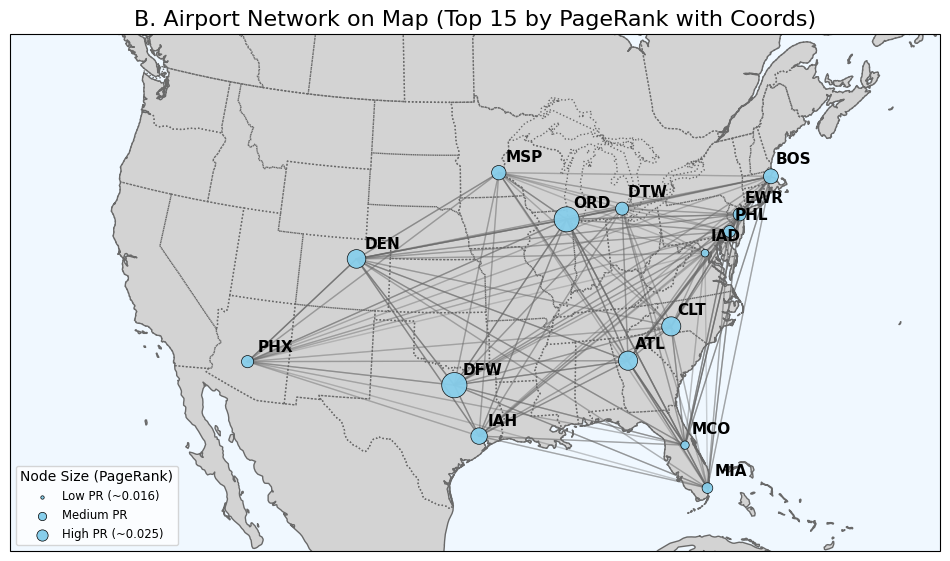

Map-based network visualization complete.


In [34]:
def visualize_network(G, centrality_df, top_n_visual=25, layout_seed=42):
    if not G.nodes() or top_n_visual <= 0 or centrality_df.empty:
        print("Skipping visualization: Requirements not met.")
        return

    print(f"Starting map-based network visualization (Top {top_n_visual} airports)...")
    if 'PageRank' not in centrality_df.columns or 'Airport' not in centrality_df.columns:
        print("Error: Required columns missing in centrality_df.")
        return
    # --- Airport Coordinates ---
    airport_coords = {
        'ATL': (-84.4277, 33.6407), 'LAX': (-118.4085, 33.9416), 'ORD': (-87.9073, 41.9742),
        'DFW': (-97.0403, 32.8998), 'DEN': (-104.6737, 39.8617), 'JFK': (-73.7781, 40.6413),
        'SFO': (-122.3790, 37.6213), 'SEA': (-122.3088, 47.4502), 'LAS': (-115.1537, 36.0840),
        'MCO': (-81.3081, 28.4312), 'EWR': (-74.1745, 40.6895), 'CLT': (-80.9431, 35.2144),
        'PHX': (-112.0116, 33.4343), 'MIA': (-80.2871, 25.7959), 'BOS': (-71.0064, 42.3656),
        'MSP': (-93.2223, 44.8848), 'FLL': (-80.1527, 26.0742), 'DTW': (-83.3534, 42.2162),
        'PHL': (-75.2424, 39.8744), 'LGA': (-73.8740, 40.7769), 'BWI': (-76.6683, 39.1774),
        'SLC': (-111.9791, 40.7884), 'IAD': (-77.4565, 38.9531), 'DCA': (-77.0365, 38.8512),
        'SAN': (-117.1933, 32.7338), 'TPA': (-82.5332, 27.9755), 'IAH': (-95.3414, 29.9902),
        'AUS': (-97.6700, 30.1975),  'MDW': (-87.7522, 41.7868)
    }

    # --- Prepare subgraph and positions ---
    centrality_df_sorted = centrality_df.sort_values('PageRank', ascending=False)
    top_airports_visual = centrality_df_sorted['Airport'].head(top_n_visual).tolist()
    sub_graph = G.subgraph(top_airports_visual)

    if not sub_graph.nodes():
        print("Warning: Subgraph for visualization has no nodes.")
        return

    pos = {}
    nodes_to_draw = []
    missing_coords = []
    for node in sub_graph.nodes():
        if node in airport_coords:
            pos[node] = airport_coords[node] # Store (lon, lat)
            nodes_to_draw.append(node)
        else:
            missing_coords.append(node)


    # --- Create Map Plot ---
    plt.figure(figsize=(12, 16))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-97.5, central_latitude=38.5))
    ax.set_extent([-125, -66.5, 20, 50], crs=ccrs.Geodetic())

    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0) # Set zorder
    ax.add_feature(cfeature.OCEAN, facecolor='aliceblue', zorder=0)
    ax.add_feature(cfeature.COASTLINE, edgecolor='dimgray', zorder=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=1)
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='dimgray', zorder=1)

    # --- Draw Network ---
    # Node size scaled by PageRank
    pagerank_scores = {node: centrality_df_sorted.set_index('Airport').loc[node, 'PageRank']
                    for node in nodes_to_draw if node in centrality_df_sorted['Airport'].values}
    if not pagerank_scores:
        node_sizes = [30] * len(nodes_to_draw)
        min_pr, max_pr = 0, 0
    else:
        min_pr, max_pr = min(pagerank_scores.values()), max(pagerank_scores.values())
        node_sizes = [30 + 300 * (pagerank_scores.get(node, min_pr) - min_pr) / (max_pr - min_pr + 1e-9) for node in nodes_to_draw]

    # Edge alpha scaled by flight count
    edges_to_draw = [(u, v) for u, v in sub_graph.edges() if u in pos and v in pos]
    edge_counts = [sub_graph[u][v].get('count', 1) for u, v in edges_to_draw]
    edge_alphas = []
    if edge_counts:
        min_count, max_count = min(edge_counts), max(edge_counts)
        # Adjust alpha scaling for better visibility
        edge_alphas = [0.15 + 0.6 * (count - min_count) / (max_count - min_count + 1e-9) for count in edge_counts]

    # *** Draw Edges using ax.plot and slightly thicker lines ***
    for i, (u, v) in enumerate(edges_to_draw):
        lon1, lat1 = pos[u]
        lon2, lat2 = pos[v]
        # Use ax.plot instead of plt.plot
        ax.plot([lon1, lon2], [lat1, lat2],
                color='dimgray', # Slightly darker color
                linewidth=1.0, # Slightly thicker line
                alpha=edge_alphas[i] if edge_alphas else 0.4, # Use scaled alpha
                transform=ccrs.Geodetic(), # Specify coordinates are lat/lon
                zorder=2) # Draw edges above land/ocean but below nodes

    # Draw Nodes using ax.scatter
    lons = [pos[node][0] for node in nodes_to_draw]
    lats = [pos[node][1] for node in nodes_to_draw]
    ax.scatter(lons, lats, s=node_sizes,
            c='skyblue', alpha=0.95, edgecolors='black', linewidths=0.5,
            transform=ccrs.PlateCarree(), zorder=3) # Draw nodes on top

    # Draw Labels
    for node in nodes_to_draw:
        lon, lat = pos[node]
        ax.text(lon + 0.6, lat + 0.6, node,
                fontsize=11, fontweight='bold',
                transform=ccrs.Geodetic(),
                zorder=4) # Draw labels on the very top

    # Add legend for node size
    if pd.notna(min_pr) and pd.notna(max_pr) and max_pr > min_pr:
        l1 = plt.scatter([],[], s=(30)/5, color='skyblue', edgecolors='black', linewidths=0.5)
        l2 = plt.scatter([],[], s=(30 + 300 * 0.5)/5, color='skyblue', edgecolors='black', linewidths=0.5)
        l3 = plt.scatter([],[], s=(30 + 300)/5, color='skyblue', edgecolors='black', linewidths=0.5)
        plt.legend([l1, l2, l3], [f'Low PR (~{min_pr:.3f})', 'Medium PR', f'High PR (~{max_pr:.3f})'],
                title='Node Size (PageRank)', loc='lower left', fontsize='small', title_fontsize='medium', frameon=True)

    plt.title(f"B. Airport Network on Map (Top {len(nodes_to_draw)} by PageRank with Coords)", fontsize=16)
    plt.savefig(os.path.join(plot_dir, 'network_map_visualization.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("Map-based network visualization complete.")

# Execute network visualization
if 'network_graph_b' in locals() and 'network_results_b' in locals() and not network_results_b.empty:
    visualize_network(network_graph_b, network_results_b, top_n_visual=15)
else:
    print("Skipping network visualization.")

## 4.B.2: Delay Propagation Simulation (SIR Model)

In [35]:
def sir_simulation(G, initial_infected_nodes, beta=0.05, gamma=0.1, steps=30, runs=20):
    """Simulates delay propagation using the SIR model."""
    if not G.nodes(): return pd.DataFrame()
    print(f"Starting SIR simulation (Initial: {initial_infected_nodes}, beta={beta}, gamma={gamma})...")
    all_results = []
    if isinstance(initial_infected_nodes, str): initial_infected_nodes = [initial_infected_nodes]
    valid_initial_nodes = [node for node in initial_infected_nodes if node in G.nodes]
    if not valid_initial_nodes: return pd.DataFrame()

    for run in range(runs):
        states = {node: 'S' for node in G.nodes}
        for node in valid_initial_nodes: states[node] = 'I'
        current_infected = set(valid_initial_nodes)
        run_results = []

        for step in range(steps):
            newly_infected = set()
            newly_recovered = set()
            infecting_nodes = list(current_infected)

            for node in infecting_nodes:
                if states[node] == 'I':
                    for neighbor in G.successors(node):
                        if states[neighbor] == 'S' and np.random.rand() < beta:
                            newly_infected.add(neighbor)

            recovering_nodes = list(current_infected)
            for node in recovering_nodes:
                 if states[node] == 'I' and np.random.rand() < gamma:
                    newly_recovered.add(node)

            for node in newly_infected: states[node] = 'I'
            for node in newly_recovered: states[node] = 'R'
            current_infected = (current_infected.union(newly_infected)) - newly_recovered

            counts = {'S': 0, 'I': 0, 'R': 0}
            for state in states.values(): counts[state] += 1
            counts['step'] = step
            counts['run'] = run
            run_results.append(counts)
        all_results.extend(run_results)

    if not all_results: return pd.DataFrame()
    results_df = pd.DataFrame(all_results)
    avg_results = results_df.groupby('step')[['S', 'I', 'R']].mean().reset_index()
    print("SIR simulation complete.")
    return avg_results


Running SIR Simulation from: DFW
Starting SIR simulation (Initial: DFW, beta=0.05, gamma=0.1)...
SIR simulation complete.


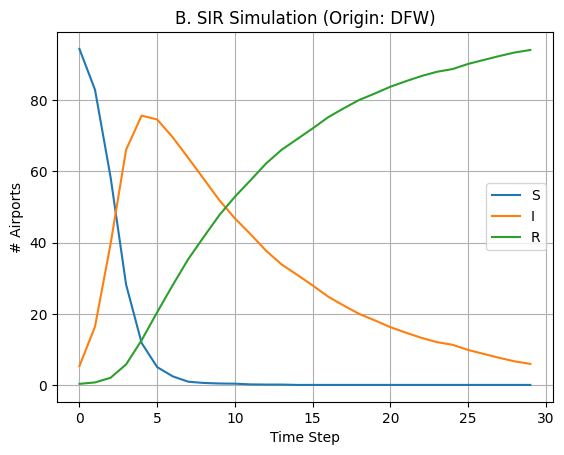

In [36]:
# Execute SIR simulation
sir_results_df = pd.DataFrame()
top_hub_airport = None

if 'network_results_b' in locals() and not network_results_b.empty:
    top_hub_airport = network_results_b['Airport'].iloc[0]
    if top_hub_airport and 'network_graph_b' in locals() and network_graph_b.nodes():
        print(f"\nRunning SIR Simulation from: {top_hub_airport}")
        sir_results_df = sir_simulation(network_graph_b, top_hub_airport)
        if not sir_results_df.empty:
            sir_results_df.plot(x='step', y=['S', 'I', 'R'],
                                  title=f"B. SIR Simulation (Origin: {top_hub_airport})",
                                  xlabel="Time Step", ylabel="# Airports", grid=True)
            plt.show()
        else: print("SIR simulation produced no results.")
    else: print("Could not run SIR (missing hub/graph).")
else: print("Skipping SIR simulation.")

## 4.B.3: Actual Delay Tracing (Example) <- No multi-leg routes found for tracing.

In [37]:
# Trace actual delays along routes
print("\n--- B.3: Tracing Actual Delay Propagation (Examples) ---")

if 'df_processed' in locals() and not df_processed.empty and 'D_a_i_minus1' in df_processed.columns:
    if 'ROUTE_KEY' not in df_processed.columns:
        # Attempt to recreate ROUTE_KEY if needed and possible
        if all(col in df_processed.columns for col in ['AIRLINE', 'FL_NUMBER', 'ORIGIN', 'FL_DATE']):
             if not pd.api.types.is_datetime64_any_dtype(df_processed['FL_DATE']):
                  df_processed['FL_DATE'] = pd.to_datetime(df_processed['FL_DATE'])
             df_processed['ROUTE_KEY'] = (
                 df_processed['AIRLINE'].astype(str) + "_" + df_processed['FL_NUMBER'].astype(str) + "_" +
                 df_processed['ORIGIN'].astype(str) + "_" + df_processed['FL_DATE'].dt.strftime("%Y-%m-%d")
             )
        else: df_processed['ROUTE_KEY'] = None

    if 'ROUTE_KEY' in df_processed.columns and df_processed['ROUTE_KEY'] is not None:
        route_counts = df_processed['ROUTE_KEY'].value_counts()
        multi_leg_routes = route_counts[route_counts > 1].index.tolist()

        if multi_leg_routes:
            num_examples = min(3, len(multi_leg_routes))
            example_routes = random.sample(multi_leg_routes, num_examples)
            print(f"Showing delay traces for {num_examples} sample routes:")
            for route in example_routes:
                route_df = df_processed[df_processed['ROUTE_KEY'] == route].sort_values('CRS_DEP_TIME')
                if len(route_df) > 1:
                    plt.figure(figsize=(8, 4))
                    plt.plot(route_df['DEST'], route_df['D_a_i_minus1'], marker='o', linestyle='--', label='D_a_i_minus1')
                    plt.plot(route_df['DEST'], route_df['ARR_DELAY_raw'], marker='x', linestyle='-', label='ARR_DELAY_raw')
                    if 'DEP_DELAY_raw' in route_df.columns:
                         plt.plot(route_df['DEST'], route_df['DEP_DELAY_raw'], marker='s', linestyle=':', label='DEP_DELAY_raw', alpha=0.7)
                    plt.title(f"Delay Trace: {route}")
                    plt.xlabel("Destination (Sequence)"); plt.ylabel("Delay (min)")
                    plt.legend(); plt.grid(True, axis='y'); plt.tight_layout(); plt.show()
        else: print("No multi-leg routes found for tracing.")
    else: print("ROUTE_KEY not available for tracing.")
else: print("Skipping actual delay tracing: df_processed/D_a_i_minus1 missing.")


--- B.3: Tracing Actual Delay Propagation (Examples) ---
No multi-leg routes found for tracing.


## 4.B.4: Network Validation (Centrality vs. Simulation/Actual Delay)


--- B.4: Validating Network Centrality ---
Top 10 PageRank: ['DFW', 'ORD', 'ATL', 'CLT', 'DEN', 'IAH', 'BOS', 'MSP', 'DTW', 'EWR']
Top 10 Betweenness: ['ORD', 'DEN', 'ATL', 'DFW', 'LAS', 'MDW', 'CLT', 'MSP', 'IAH', 'PHX']

SIR simulation started from: DFW

Top 10 Airports by Mean Actual Arr Delay: ['PNS', 'VPS', 'FAT', 'RIC', 'OKC', 'SDF', 'RSW', 'XNA', 'ALB', 'SRQ']
Overlap (PageRank & Mean Delay): set()
Overlap (Betweenness & Mean Delay): set()

SIR 시뮬레이션-실제 지연 상관계수: 0.221 (p=0.240)


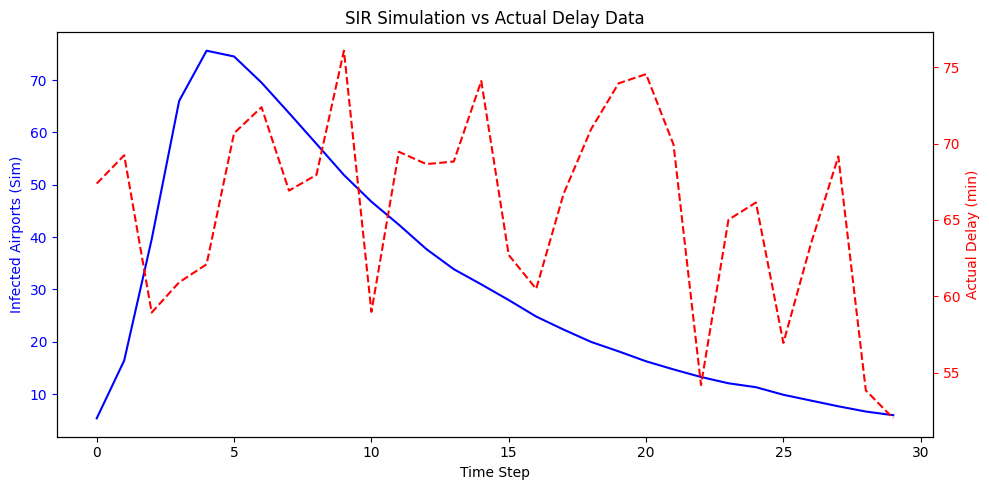

Network validation comparison complete.


In [ ]:
print("\n--- B.4: Validating Network Centrality ---")

validation_possible = False
if 'network_results_b' in locals() and not network_results_b.empty:
    top_pagerank_airports = network_results_b.sort_values('PageRank', ascending=False)['Airport'].head(10).tolist()
    top_betweenness_airports = network_results_b.sort_values('Betweenness', ascending=False)['Airport'].head(10).tolist()
    print(f"Top 10 PageRank: {top_pagerank_airports}")
    print(f"Top 10 Betweenness: {top_betweenness_airports}")
    validation_possible = True
else: print("Network centrality results missing.")

if 'sir_results_df' in locals() and not sir_results_df.empty and validation_possible:
    print(f"\nSIR simulation started from: {top_hub_airport if top_hub_airport else 'N/A'}")
    # Note: Further analysis could compare infection frequency per node vs centrality.
else: print("\nSIR simulation results missing.")

if 'df_processed' in locals() and not df_processed.empty and validation_possible:
    if 'ORIGIN' in df_processed.columns and 'ARR_DELAY_raw' in df_processed.columns:
        mean_delays = df_processed[df_processed['ORIGIN'].isin(network_results_b['Airport'])]\
                                .groupby('ORIGIN')['ARR_DELAY_raw'].mean().sort_values(ascending=False)
        top_mean_delay_airports = mean_delays.head(10).index.tolist()
        print(f"\nTop 10 Airports by Mean Actual Arr Delay: {top_mean_delay_airports}")
        pr_delay_overlap = set(top_pagerank_airports).intersection(set(top_mean_delay_airports))
        btw_delay_overlap = set(top_betweenness_airports).intersection(set(top_mean_delay_airports))
        print(f"Overlap (PageRank & Mean Delay): {pr_delay_overlap}")
        print(f"Overlap (Betweenness & Mean Delay): {btw_delay_overlap}")
    else: print("\nMean delay info missing for comparison.")
else: print("\nActual delay data missing.")


if 'sir_results_df' in locals() and not sir_results_df.empty:
    # Extract actual delays for the airports in the simulation
    actual_delay = df_processed.groupby('ORIGIN')['ARR_DELAY_raw'].mean()[network_results_b['Airport']]
    
    # Analysis for correlation between SIR simulation and actual delays
    from scipy.stats import pearsonr
    corr, p_val = pearsonr(sir_results_df['I'], actual_delay.values[:len(sir_results_df)])
    print(f"\nSIR Simulation-Actual Delay Correlation Coefficient: {corr:.3f} (p={p_val:.3f})")
    
    fig, ax1 = plt.subplots(figsize=(10,5))
    
    ax1.plot(sir_results_df['step'], sir_results_df['I'], 'b-', label='시뮬레이션')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Infected Airports (Sim)', color='b')
    ax1.tick_params('y', colors='b')
    
    ax2 = ax1.twinx()
    ax2.plot(sir_results_df['step'], actual_delay.values[:len(sir_results_df)], 'r--', label='실제 지연')
    ax2.set_ylabel('Actual Delay (min)', color='r')
    ax2.tick_params('y', colors='r')
    
    plt.title('SIR Simulation vs Actual Delay Data')
    fig.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'sir_validation.png'), dpi=300)
    plt.show()
print("Network validation comparison complete.")



## B.5: Network Validation (Centrality vs. Mean Actual Delay)


--- B.5: Validating Network Centrality vs. Mean Actual Delay ---
Network centrality results available.

Calculating mean actual arrival delay per airport...

Comparing centrality and mean actual delay for 100 common airports.
Spearman Correlation (PageRank vs Mean Delay): rho=-0.288, p-value=0.004
Spearman Correlation (Betweenness vs Mean Delay): rho=-0.388, p-value=0.000
Pearson Correlation (PageRank vs Mean Delay): r=-0.231, p-value=0.021
Pearson Correlation (Betweenness vs Mean Delay): r=-0.325, p-value=0.001
Saved scatter plots to /Users/jh/Desktop/flightProj/plots/centrality_vs_mean_delay_correlation.png


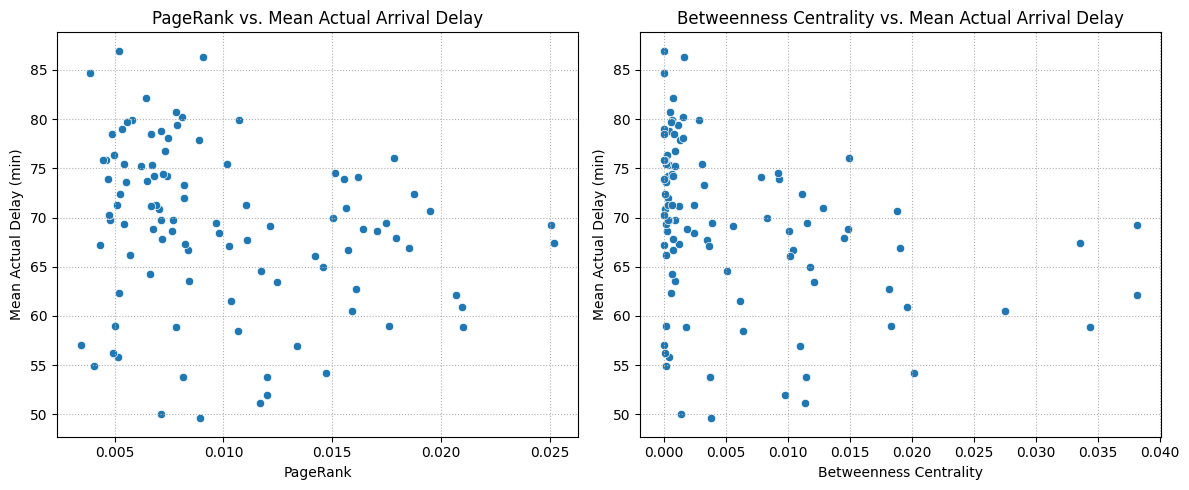

In [ ]:
print("\n--- B.5: Validating Network Centrality vs. Mean Actual Delay ---")

validation_possible = False
if 'network_results_b' in locals() and not network_results_b.empty:
    if 'Airport' in network_results_b.columns and 'PageRank' in network_results_b.columns and 'Betweenness' in network_results_b.columns:
        validation_possible = True
        print("Network centrality results available.")
    else:
        print("Network results missing required centrality columns.")
else:
    print("Network centrality results missing.")

if validation_possible and 'df_processed' in locals() and not df_processed.empty:
    if 'ORIGIN' in df_processed.columns and 'ARR_DELAY_raw' in df_processed.columns:

        print("\nCalculating mean actual arrival delay per airport...")
        # Calculate mean arrival delay for each airport that is in our network analysis results
        mean_delays_by_airport = df_processed[df_processed['ORIGIN'].isin(network_results_b['Airport'])]\
                                .groupby('ORIGIN')['ARR_DELAY_raw'].mean()

        if not mean_delays_by_airport.empty:
            # Merge mean delays with centrality results based on airport code
            merged_validation_df = pd.merge(
                network_results_b[['Airport', 'PageRank', 'Betweenness']],
                mean_delays_by_airport.reset_index(name='Mean_Actual_Delay'),
                left_on='Airport',
                right_on='ORIGIN',
                how='inner' # Use inner join to compare only common airports
            ).drop(columns='ORIGIN') # Drop redundant origin column

            if not merged_validation_df.empty and len(merged_validation_df) > 1:
                print(f"\nComparing centrality and mean actual delay for {len(merged_validation_df)} common airports.")

                # Perform correlations
                from scipy.stats import spearmanr, pearsonr

                # PageRank vs Mean Delay (Spearman is often better for skewed network metrics)
                spearman_pr, p_value_pr = spearmanr(merged_validation_df['PageRank'], merged_validation_df['Mean_Actual_Delay'])
                print(f"Spearman Correlation (PageRank vs Mean Delay): rho={spearman_pr:.3f}, p-value={p_value_pr:.3f}")

                # Betweenness vs Mean Delay (Spearman)
                spearman_btw, p_value_btw = spearmanr(merged_validation_df['Betweenness'], merged_validation_df['Mean_Actual_Delay'])
                print(f"Spearman Correlation (Betweenness vs Mean Delay): rho={spearman_btw:.3f}, p-value={p_value_btw:.3f}")

                # Optional: Pearson correlation as well
                pearson_pr, p_value_pr_p = pearsonr(merged_validation_df['PageRank'], merged_validation_df['Mean_Actual_Delay'])
                print(f"Pearson Correlation (PageRank vs Mean Delay): r={pearson_pr:.3f}, p-value={p_value_pr_p:.3f}")
                pearson_btw, p_value_btw_p = pearsonr(merged_validation_df['Betweenness'], merged_validation_df['Mean_Actual_Delay'])
                print(f"Pearson Correlation (Betweenness vs Mean Delay): r={pearson_btw:.3f}, p-value={p_value_btw_p:.3f}")


                # Optional: Scatter plots to visualize the correlation
                plt.figure(figsize=(12, 5))

                plt.subplot(1, 2, 1)
                sns.scatterplot(data=merged_validation_df, x='PageRank', y='Mean_Actual_Delay')
                plt.title('PageRank vs. Mean Actual Arrival Delay')
                plt.xlabel('PageRank')
                plt.ylabel('Mean Actual Delay (min)')
                plt.grid(True, linestyle=':')

                plt.subplot(1, 2, 2)
                sns.scatterplot(data=merged_validation_df, x='Betweenness', y='Mean_Actual_Delay')
                plt.title('Betweenness Centrality vs. Mean Actual Arrival Delay')
                plt.xlabel('Betweenness Centrality')
                plt.ylabel('Mean Actual Delay (min)')
                plt.grid(True, linestyle=':')

                plt.tight_layout()
                plot_path = os.path.join(plot_dir, 'centrality_vs_mean_delay_correlation.png')
                plt.savefig(plot_path, dpi=150, bbox_inches='tight')
                print(f"Saved scatter plots to {plot_path}")
                plt.show()

            else:
                print("Not enough common airports with mean delay data for correlation analysis.")
        else:
            print("Could not calculate mean actual delay for network airports.")

    else:
        print("Required columns ('ORIGIN', 'ARR_DELAY_raw') not in df_processed for mean delay calculation.")
else:
    print("Skipping Centrality vs. Mean Actual Delay validation.")

# 5: Merge Network Features into Main DataFrame

In [39]:
print("\n--- Step 3: Merging network centrality features ---")
df_final = pd.DataFrame()

if 'df_processed' in locals() and not df_processed.empty:
    if 'network_results_b' in locals() and not network_results_b.empty:
        required_network_cols = ['Airport', 'PageRank', 'Betweenness']
        if all(col in network_results_b.columns for col in required_network_cols):
            df_merged = df_processed.copy()
            df_merged = pd.merge(df_merged, network_results_b[required_network_cols], left_on='ORIGIN', right_on='Airport', how='left')
            df_merged.rename(columns={'PageRank': 'ORIGIN_PageRank', 'Betweenness': 'ORIGIN_Betweenness'}, inplace=True)
            df_merged.drop(columns='Airport', inplace=True, errors='ignore')
            df_merged = pd.merge(df_merged, network_results_b[required_network_cols], left_on='DEST', right_on='Airport', how='left')
            df_merged.rename(columns={'PageRank': 'DEST_PageRank', 'Betweenness': 'DEST_Betweenness'}, inplace=True)
            df_merged.drop(columns='Airport', inplace=True, errors='ignore')
            network_cols_to_fill = ['ORIGIN_PageRank', 'ORIGIN_Betweenness', 'DEST_PageRank', 'DEST_Betweenness']
            for col in network_cols_to_fill: df_merged[col].fillna(0, inplace=True)
            df_final = df_merged.copy()
            print(f"Network features merged. Final data shape: {df_final.shape}")
        else:
            print(f"Warning: Network results missing columns. Proceeding without network features.")
            df_final = df_processed.copy()
    else:
        print("Warning: Network results missing. Proceeding without network features.")
        df_final = df_processed.copy()
else:
    print("Error: df_processed empty. Cannot proceed.")



--- Step 3: Merging network centrality features ---
Network features merged. Final data shape: (266932, 39)


# 6: Model Training & SHAP Analysis (Using Combined Features)

In [40]:
# Setup for Modeling (Data Split, Preprocessing)
print("\n--- Step 4: Starting Model Training Setup ---")
preprocessing_successful = False
X_train, X_test, y_train, y_test = [pd.DataFrame()] * 4
X_train_trans, X_test_trans, X_shap = [np.array([])] * 3
clean_names = []
preprocessor = None

if 'df_final' in locals() and not df_final.empty:
    TARGET = 'ARR_DELAY_raw'
    if TARGET not in df_final.columns:
        print(f"ERROR: Target '{TARGET}' not found.")
    else:
        # ** CRITICAL: Exclude target, leakage risks, identifiers **
        cols_to_exclude = [
            TARGET, 'DEP_DELAY_raw',
            'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
            'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT',
            'FL_DATE', 'FL_NUMBER', #'ORIGIN', 'DEST', # <-- Remove ORIGIN/DEST here
            'AIRLINE',
            'ROUTE_KEY'
        ]

        X = df_final.drop(columns=[col for col in cols_to_exclude if col in df_final.columns], errors='ignore')
        y = df_final[TARGET]

        if X.empty:
            print("ERROR: Feature set X is empty.")
        else:
            print(f"Features for modeling: {X.shape[1]}")
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print(f"Data split: Train {X_train.shape}, Test {X_test.shape}")

            # Identify feature types (includes network features now)
            num_feats = X_train.select_dtypes(include=np.number).columns.tolist()
            cat_feats = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
            # Ensure D_a_i_minus1, network features, AND HUB FEATURES are treated as numeric
            # ***** Add new Hub Name *****
            potential_numeric = ['D_a_i_minus1',
                            'ORIGIN_PageRank', 'DEST_PageRank',
                            'ORIGIN_Betweenness', 'DEST_Betweenness',
                            'IS_ORIGIN_HUB', 'IS_DEST_HUB'] # <-- Add hub feature
            for feat in potential_numeric:
                if feat in X_train.columns and feat not in num_feats:
                    if feat in cat_feats: cat_feats.remove(feat)
                    num_feats.append(feat)
            # Ensure TIME_OF_DAY is treated as categorical
            if 'TIME_OF_DAY' in X_train.columns and 'TIME_OF_DAY' not in cat_feats:
                if 'TIME_OF_DAY' in num_feats: num_feats.remove('TIME_OF_DAY')
                cat_feats.append('TIME_OF_DAY')

            print(f"Numeric features ({len(num_feats)}): {num_feats[:3]}...{num_feats[-3:]}")
            print(f"Categorical features ({len(cat_feats)}): {cat_feats}")

            # Define preprocessor
            transformers_list = []
            if num_feats: transformers_list.append(('num', StandardScaler(), num_feats))
            if cat_feats: transformers_list.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats))

            if not transformers_list: print("ERROR: No features for preprocessing.")
            else:
                preprocessor = ColumnTransformer(transformers=transformers_list, remainder='passthrough')
                try:
                    print("Preprocessing data...")
                    preprocessor.fit(X_train)
                    X_train_trans = preprocessor.transform(X_train)
                    X_test_trans = preprocessor.transform(X_test)
                    clean_names = list(preprocessor.get_feature_names_out()) # Ensure it's a list
                    print(f"Transformed training data shape: {X_train_trans.shape}")

                    # Sample data for SHAP
                    shap_sample_size = min(1000, X_test_trans.shape[0])
                    if shap_sample_size < X_test_trans.shape[0]:
                        sample_indices = np.random.choice(X_test_trans.shape[0], shap_sample_size, replace=False)
                        X_shap = X_test_trans[sample_indices]
                    else: X_shap = X_test_trans
                    print(f"SHAP sample size: {X_shap.shape[0]}")
                    preprocessing_successful = True
                except Exception as e: print(f"ERROR during preprocessing: {e}")
else: print("Skipping Model Training setup: df_final empty/undefined.")


--- Step 4: Starting Model Training Setup ---
Features for modeling: 28
Data split: Train (213545, 28), Test (53387, 28)
Numeric features (25): ['AIR_TIME', 'DISTANCE', 'IS_HOLIDAY']...['ORIGIN_Betweenness', 'DEST_PageRank', 'DEST_Betweenness']
Categorical features (3): ['ORIGIN', 'DEST', 'TIME_OF_DAY']
Preprocessing data...
Transformed training data shape: (213545, 783)
SHAP sample size: 1000


## 6.A.1: Model Training, Evaluation, and SHAP Analysis Loop


--- Starting Model Training and SHAP Analysis ---


Training Models & SHAP:   0%|          | 0/6 [00:00<?, ?it/s]


=== Analyzing Model: LinearRegression ===
Performance - MAE: 979396346.2335, RMSE: 116093392544.0795, R2: -1518311521840287488.0000
Calculating SHAP values...


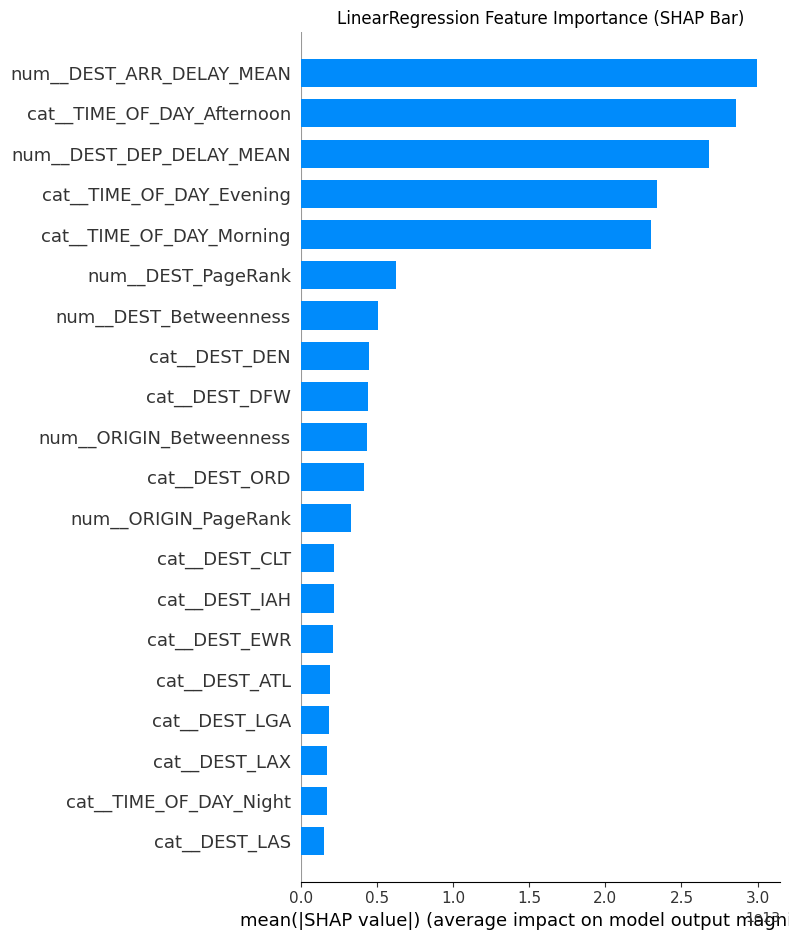

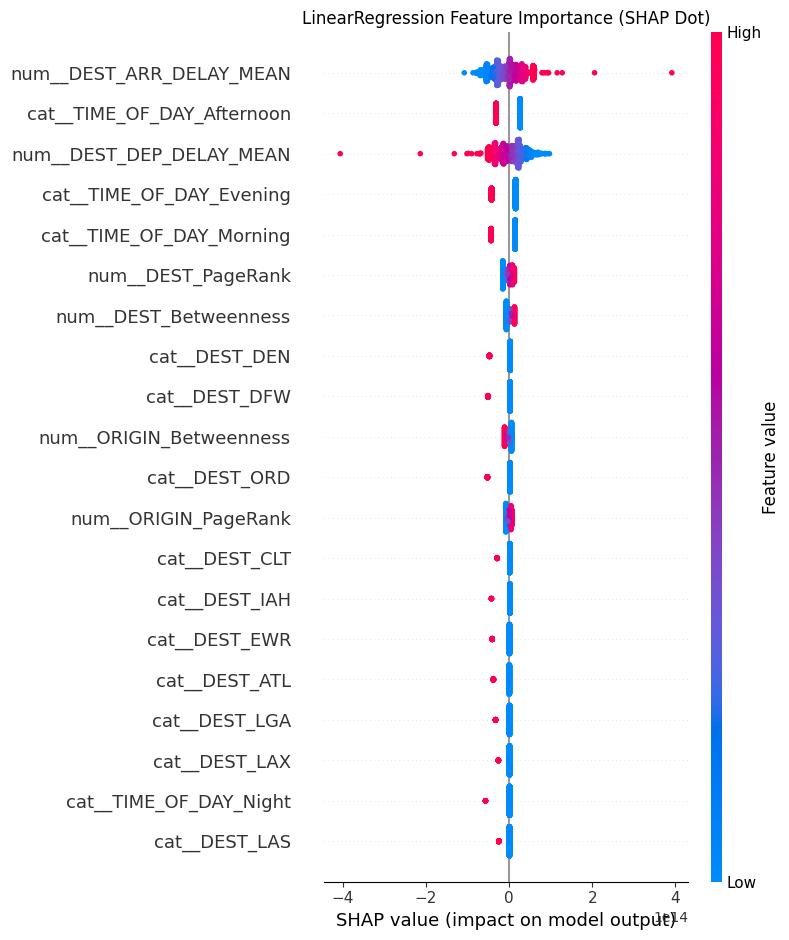


=== Analyzing Model: RandomForest ===
Performance - MAE: 48.8049, RMSE: 93.1611, R2: 0.0223
Calculating SHAP values...


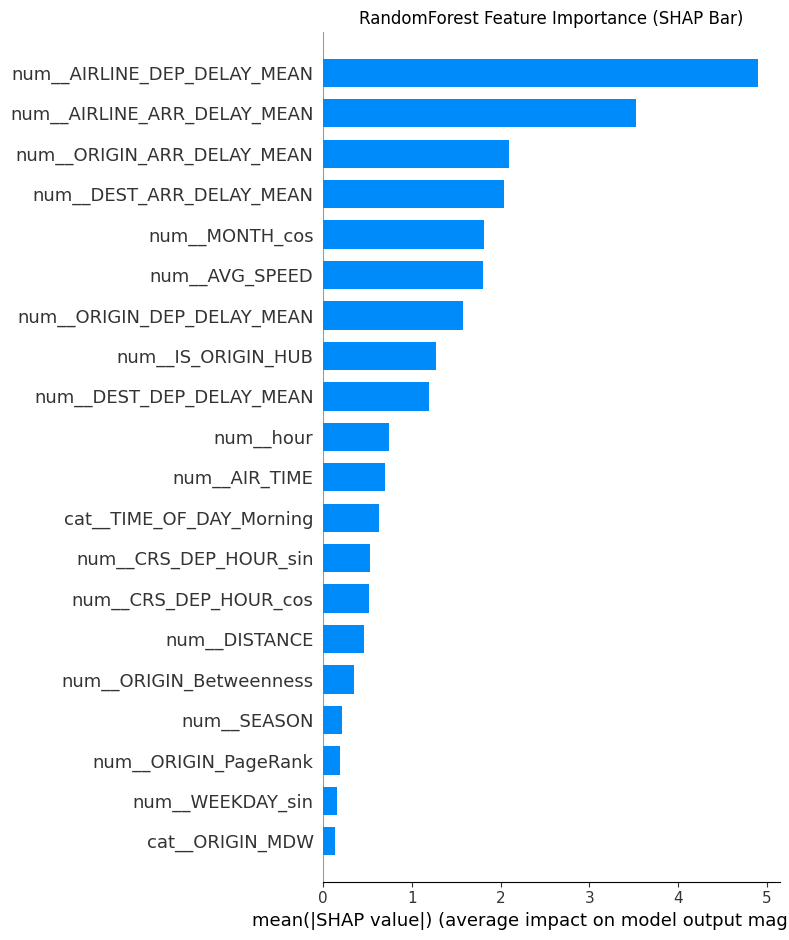

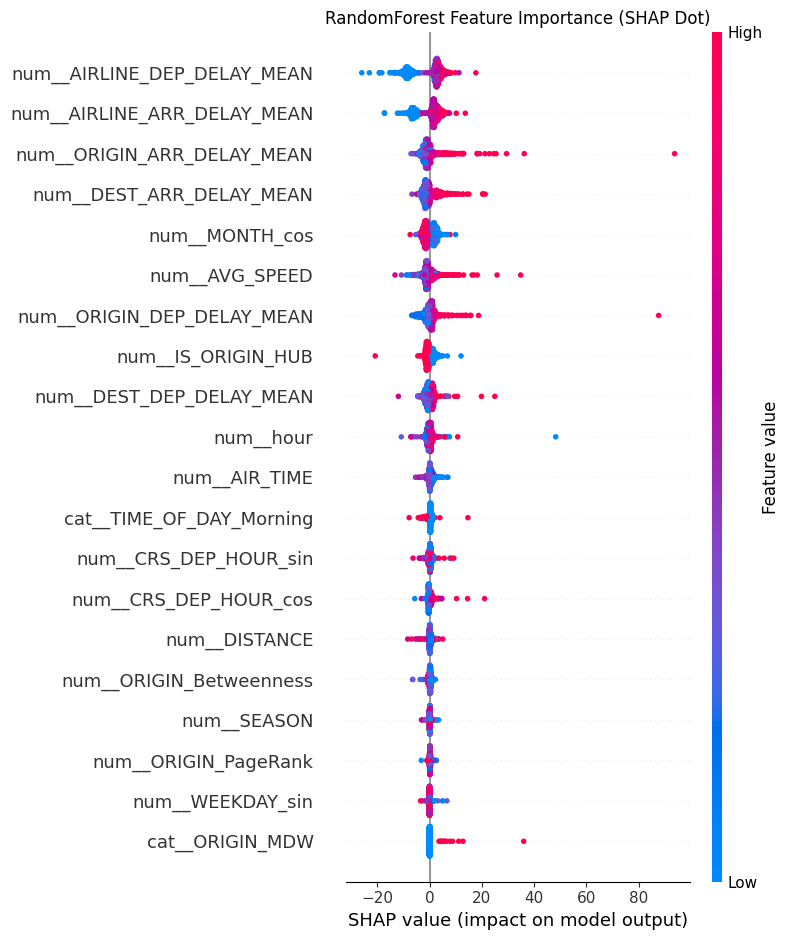


=== Analyzing Model: XGBoost ===
Performance - MAE: 48.5388, RMSE: 92.7896, R2: 0.0301
Calculating SHAP values...


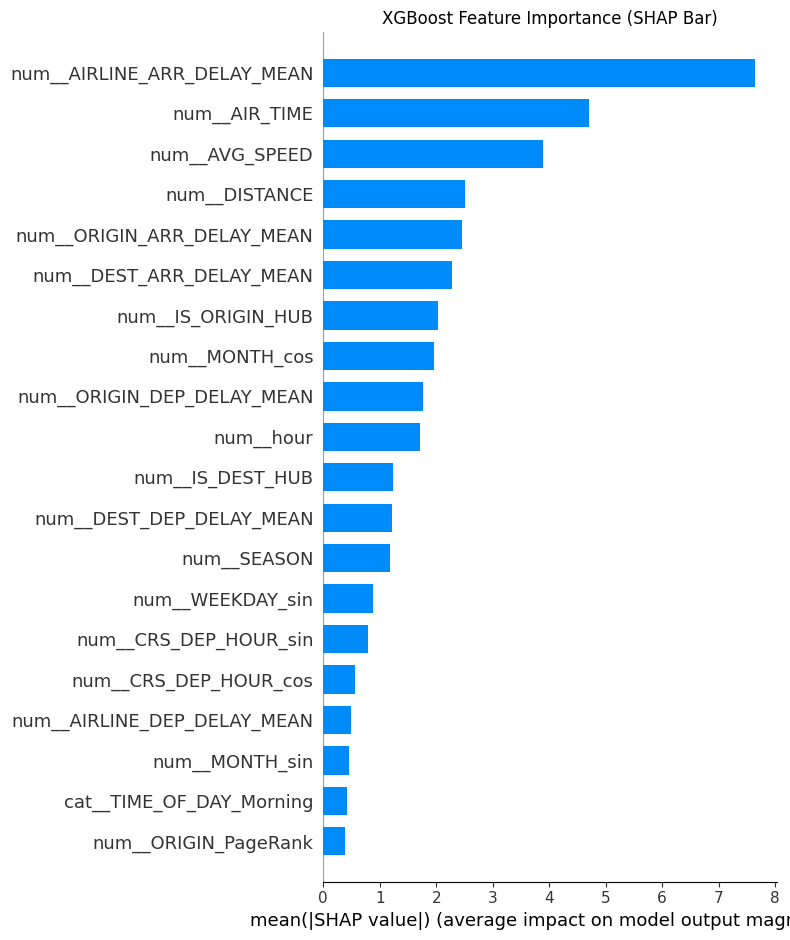

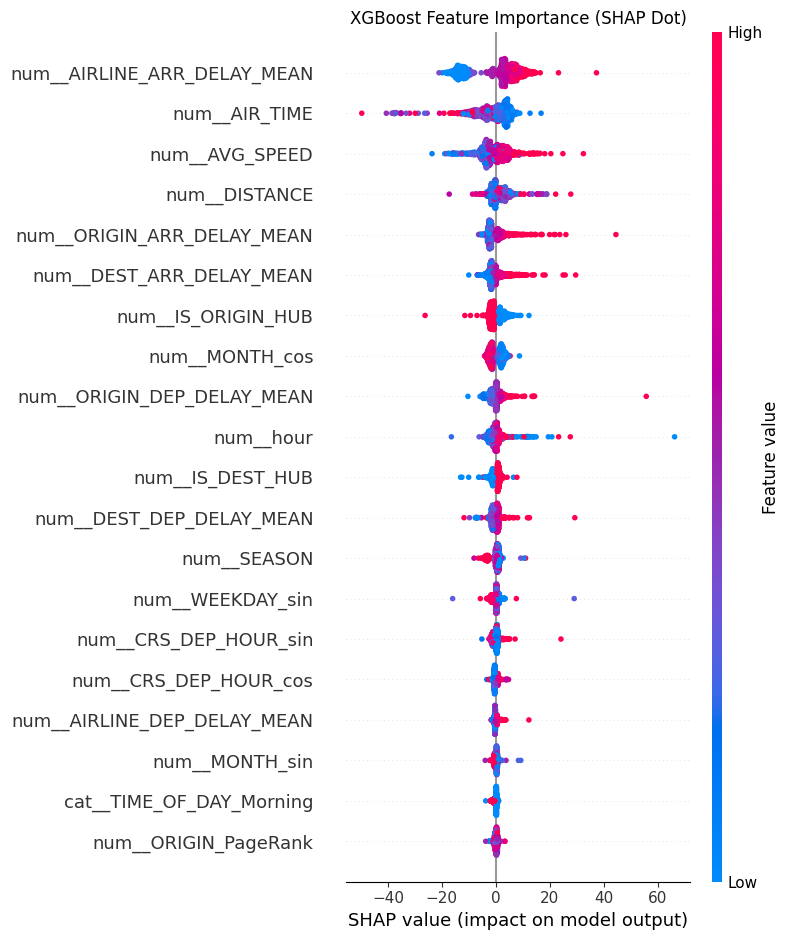


=== Analyzing Model: GradientBoosting ===
Performance - MAE: 48.6778, RMSE: 92.8551, R2: 0.0287
Calculating SHAP values...


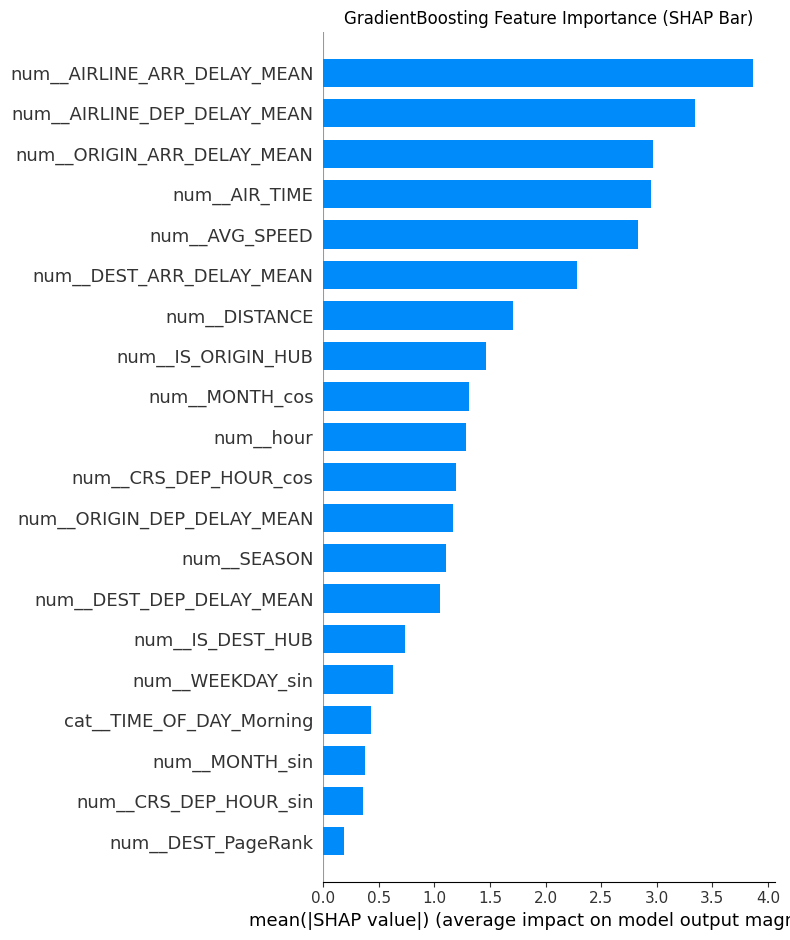

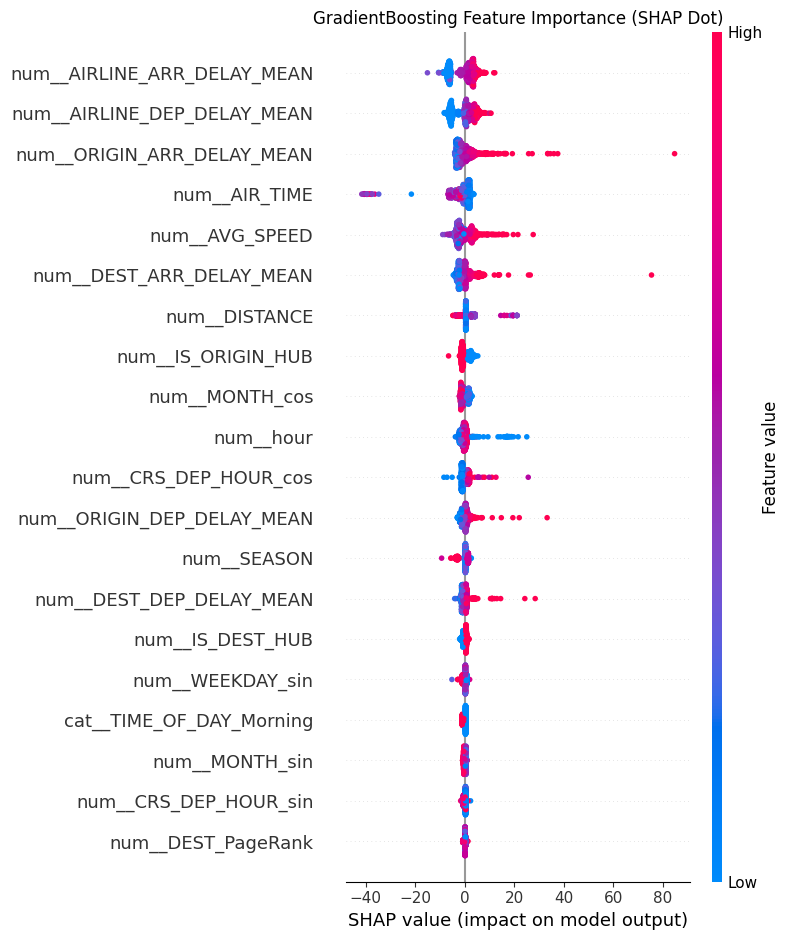


=== Analyzing Model: LightGBM ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3487
[LightGBM] [Info] Number of data points in the train set: 213545, number of used features: 609
[LightGBM] [Info] Start training from score 67.440460
Performance - MAE: 48.5410, RMSE: 92.7390, R2: 0.0311
Calculating SHAP values...


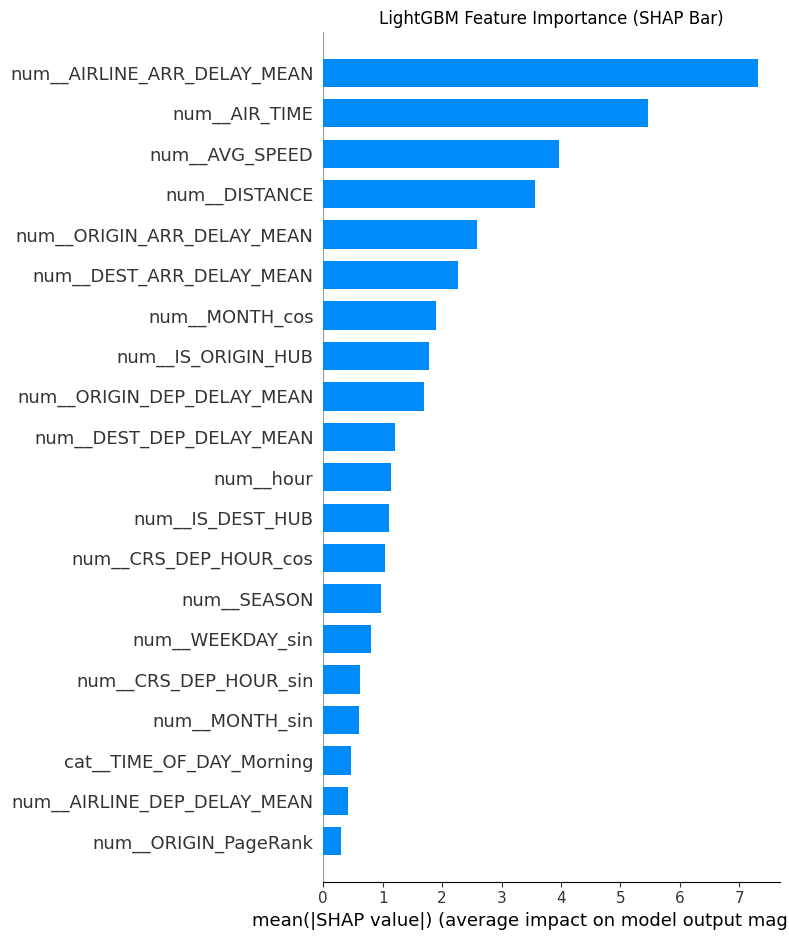

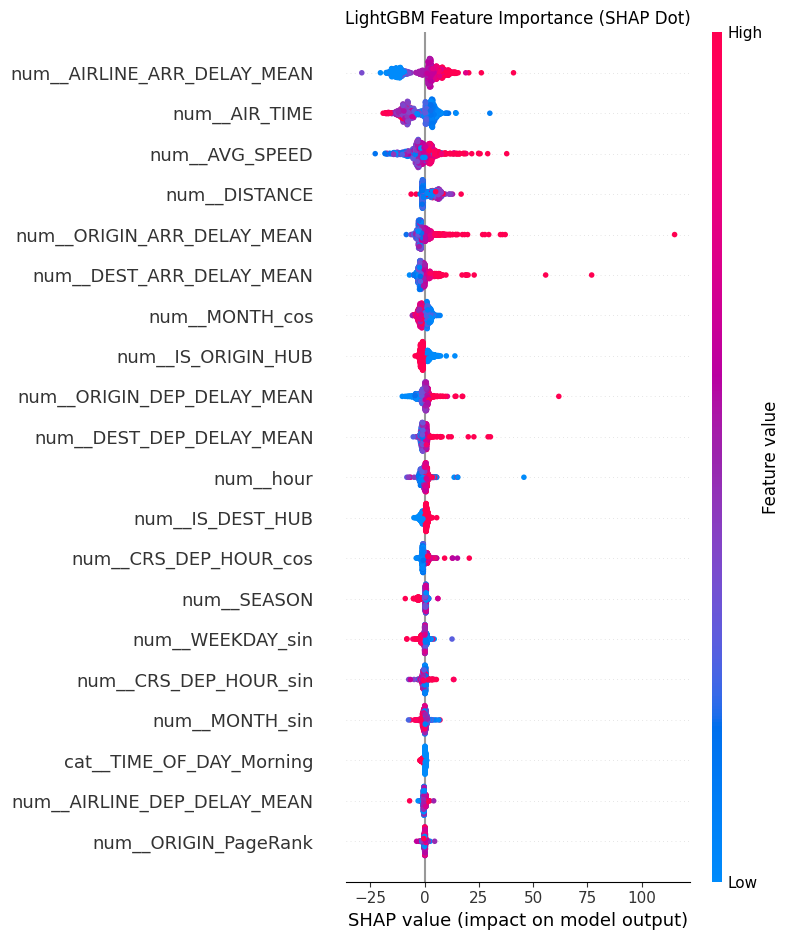


=== Analyzing Model: CatBoost ===
Performance - MAE: 48.5648, RMSE: 92.6805, R2: 0.0323
Calculating SHAP values...


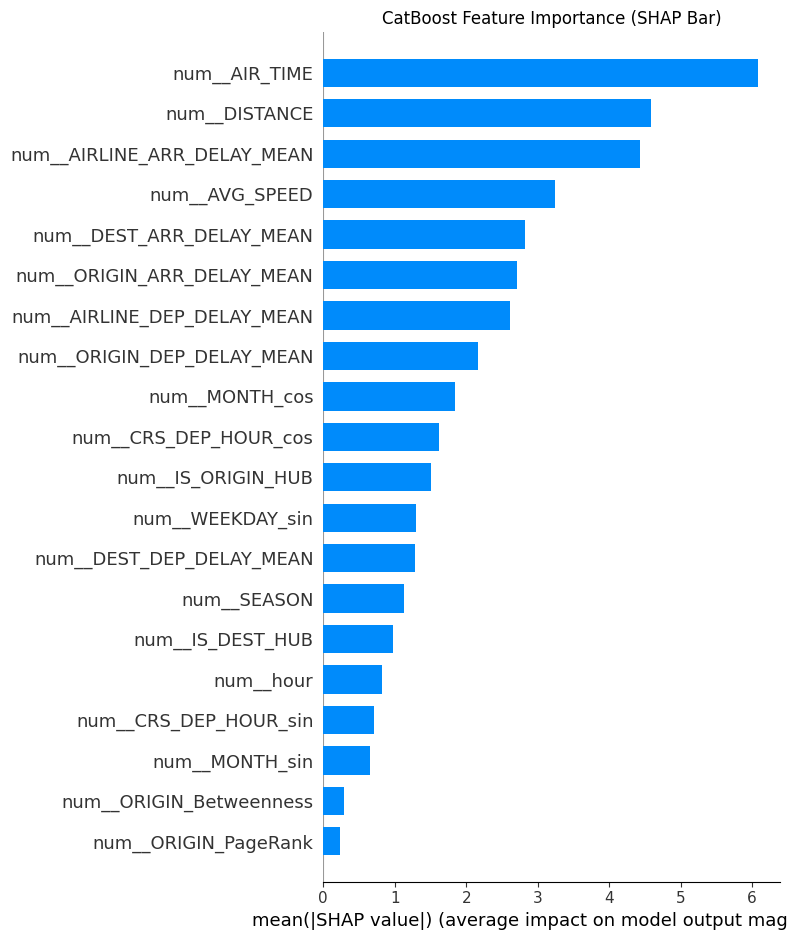

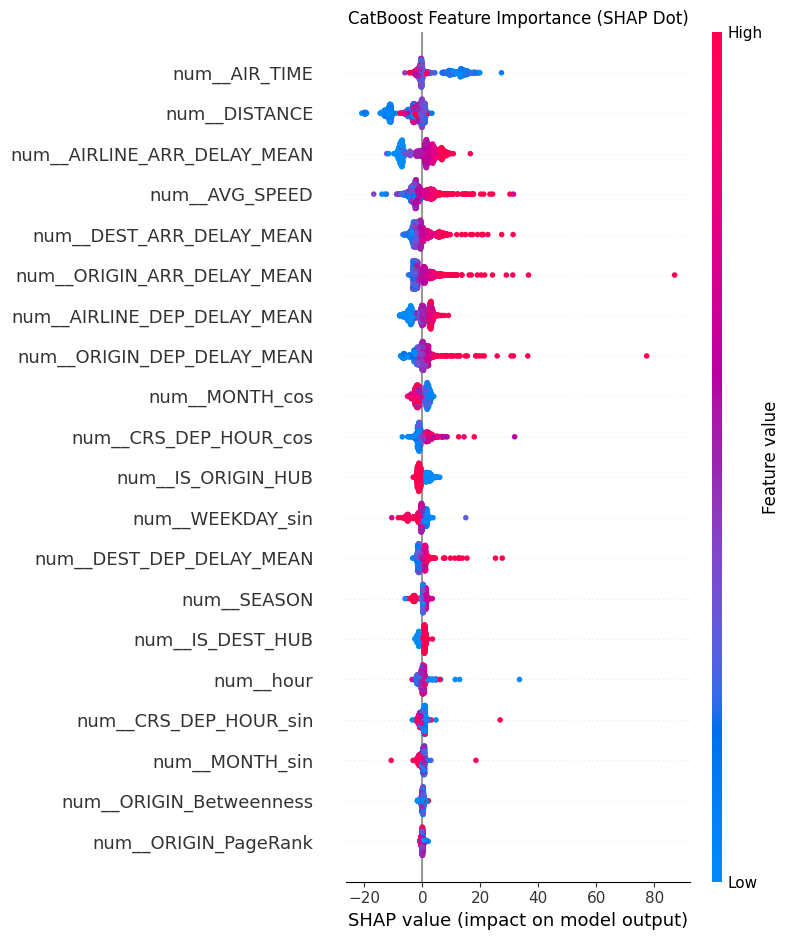


=== Analyzing Ensemble (Voting) ===
Evaluating Ensemble...
Ensemble Performance - MAE: 48.5520, RMSE: 92.6856, R2: 0.0322
Calculating approx Ensemble SHAP...


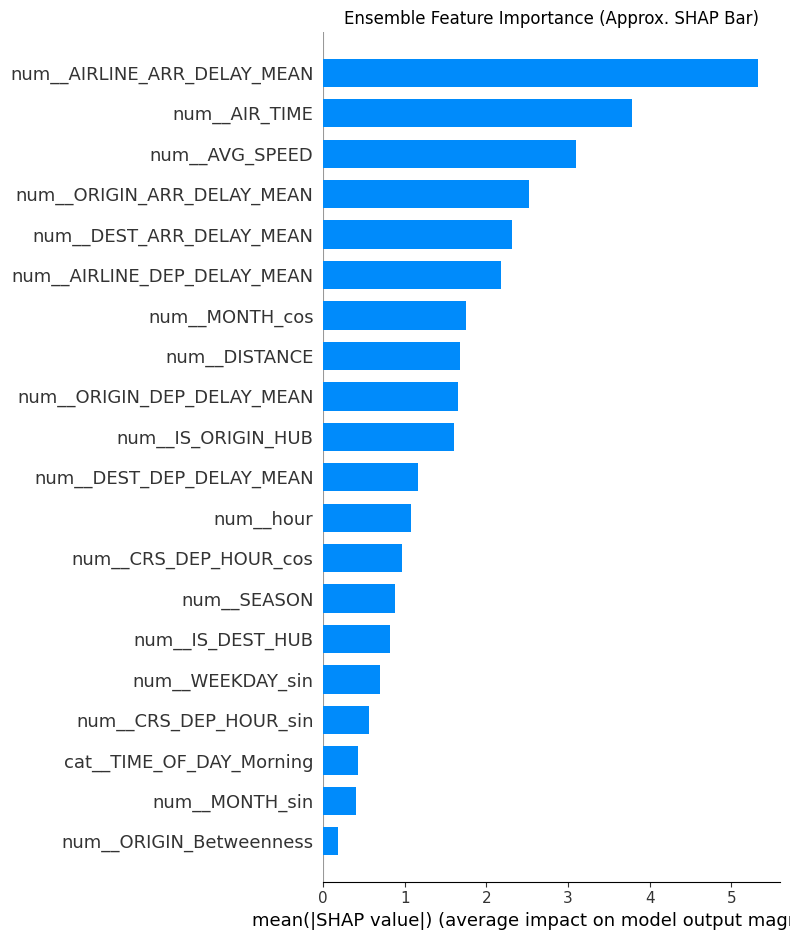

In [41]:
model_performance_a = {}
shap_values_dict_a = {}
shap_importance_dict_a = {}
trained_models = {}

if 'preprocessing_successful' in locals() and preprocessing_successful:
    print("\n--- Starting Model Training and SHAP Analysis ---")
    models_dict = {
        'LinearRegression': LinearRegression(),
        'RandomForest': RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=50, random_state=42),
        'XGBoost': XGBRegressor(n_jobs=-1, tree_method='hist', n_estimators=100, learning_rate=0.1, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
        'LightGBM': LGBMRegressor(n_jobs=-1, n_estimators=100, learning_rate=0.1, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=150, learning_rate=0.1, depth=7, verbose=0, random_state=42)
    }

    for name, model in tqdm(models_dict.items(), desc="Training Models & SHAP"):
        print(f"\n=== Analyzing Model: {name} ===")
        mdl = clone(model)
        try: # Train
            mdl.fit(X_train_trans, y_train)
            trained_models[name] = mdl
        except Exception as e: print(f"Error training {name}: {e}"); continue
        try: # Evaluate
           preds = mdl.predict(X_test_trans)
           mae = mean_absolute_error(y_test, preds)
           # --- RMSE Calculation Changed ---
           # rmse = mean_squared_error(y_test, preds, squared=False) # Old line
           mse = mean_squared_error(y_test, preds)
           rmse = np.sqrt(mse) # Calculate RMSE from MSE
           # ------------------------------
           r2 = r2_score(y_test, preds)
           model_performance_a[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
           print(f"Performance - MAE: {model_performance_a[name]['MAE']:.4f}, RMSE: {model_performance_a[name]['RMSE']:.4f}, R2: {model_performance_a[name]['R2']:.4f}")
        except Exception as e: print(f"Error evaluating {name}: {e}"); continue
        try: # SHAP
            print("Calculating SHAP values...")
            explainer = None; shap_values = None
            X_shap_np = X_shap if isinstance(X_shap, np.ndarray) else X_shap.values
            if isinstance(mdl, LinearRegression):
                background_data = shap.sample(X_train_trans, 100)
                explainer = shap.LinearExplainer(mdl, background_data)
                shap_values = explainer.shap_values(X_shap_np)
            elif name in ['RandomForest', 'GradientBoosting','XGBoost', 'LightGBM', 'CatBoost']:
                explainer = shap.TreeExplainer(mdl)
                shap_values = explainer.shap_values(X_shap_np)

            if shap_values is not None:
                if isinstance(shap_values, list): shap_values = np.array(shap_values[0])
                if not isinstance(shap_values, np.ndarray): shap_values = np.array(shap_values)
                if shap_values.shape[0] == X_shap_np.shape[0] and shap_values.shape[1] == X_shap_np.shape[1]:
                    shap_values_dict_a[name] = shap_values
                    X_shap_df_context = pd.DataFrame(X_shap_np, columns=clean_names)
                    plt.figure(figsize=(10, 7))
                    shap.summary_plot(shap_values, X_shap_df_context, plot_type='bar', show=False, max_display=20)
                    plt.title(f"{name} Feature Importance (SHAP Bar)"); plt.tight_layout(); plt.show()
                    plt.figure(figsize=(10, 7))
                    shap.summary_plot(shap_values, X_shap_df_context, plot_type='dot', show=False, max_display=20)
                    plt.title(f"{name} Feature Importance (SHAP Dot)"); plt.tight_layout(); plt.show()
                    shap_importance = pd.DataFrame(list(zip(clean_names, np.abs(shap_values).mean(axis=0))), columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
                    shap_importance_dict_a[name] = shap_importance
                else: print(f"Warning: SHAP shape mismatch for {name}.")
            else: print(f"SHAP skipped for {name}.")
        except Exception as e: print(f"Error during SHAP for {name}: {e}")

    # --- Ensemble Model Handling ---
    print("\n=== Analyzing Ensemble (Voting) ===")
    try:
        estimators = [(name, trained_models[name]) for name in ['RandomForest', 'GradientBoosting','XGBoost', 'LightGBM', 'CatBoost'] if name in trained_models]
        if len(estimators) >= 2:
            print("Evaluating Ensemble...")
            all_preds = [model.predict(X_test_trans) for name, model in estimators]
            preds_ens = np.mean(all_preds, axis=0)
            mae_ens = mean_absolute_error(y_test, preds_ens)
            # --- RMSE Calculation Changed for Ensemble ---
            mse_ens = mean_squared_error(y_test, preds_ens)
            rmse_ens = np.sqrt(mse_ens) # Calculate RMSE from MSE
            # -------------------------------------------
            r2_ens = r2_score(y_test, preds_ens)
            model_performance_a['Ensemble'] = {'MAE': mae_ens, 'RMSE': rmse_ens, 'R2': r2_ens}
            print(f"Ensemble Performance - MAE: {model_performance_a['Ensemble']['MAE']:.4f}, RMSE: {model_performance_a['Ensemble']['RMSE']:.4f}, R2: {model_performance_a['Ensemble']['R2']:.4f}")

            print("Calculating approx Ensemble SHAP...")
            base_shap_values = [shap_values_dict_a[name] for name, _ in estimators if name in shap_values_dict_a and shap_values_dict_a[name].shape == shap_values_dict_a[estimators[0][0]].shape]
            if base_shap_values:
                shap_values_ensemble = np.mean(base_shap_values, axis=0)
                shap_values_dict_a['Ensemble'] = shap_values_ensemble
                X_shap_df_context = pd.DataFrame(X_shap, columns=clean_names)
                plt.figure(figsize=(10, 7))
                shap.summary_plot(shap_values_ensemble, X_shap_df_context, plot_type='bar', show=False, max_display=20)
                plt.title("Ensemble Feature Importance (Approx. SHAP Bar)"); plt.tight_layout(); plt.show()
                shap_importance_ensemble = pd.DataFrame(list(zip(clean_names, np.abs(shap_values_ensemble).mean(axis=0))), columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
                shap_importance_dict_a['Ensemble'] = shap_importance_ensemble
            else: print("Could not calculate approx SHAP for Ensemble.")
        else: print("Not enough base models for Ensemble.")
    except Exception as e: print(f"Error during Ensemble analysis: {e}")
else:
    print("Skipping Model Training and SHAP because preprocessing failed or was skipped.")


## 6.A.2: Model Performance Comparison and Best Model Analysis


--- Step 4.A.2: Model Performance Comparison ---
                            MAE              RMSE                        R2
CatBoost                48.5648           92.6805                    0.0323
Ensemble                48.5520           92.6856                    0.0322
LightGBM                48.5410           92.7390                    0.0311
XGBoost                 48.5388           92.7896                    0.0301
GradientBoosting        48.6778           92.8551                    0.0287
RandomForest            48.8049           93.1611                    0.0223
LinearRegression 979396346.2335 116093392544.0795 -1518311521840287488.0000

Best model (by R2): CatBoost

--- Detailed Analysis for: CatBoost ---
SHAP values missing for dependence plots.

Analyzing Learning Curve...


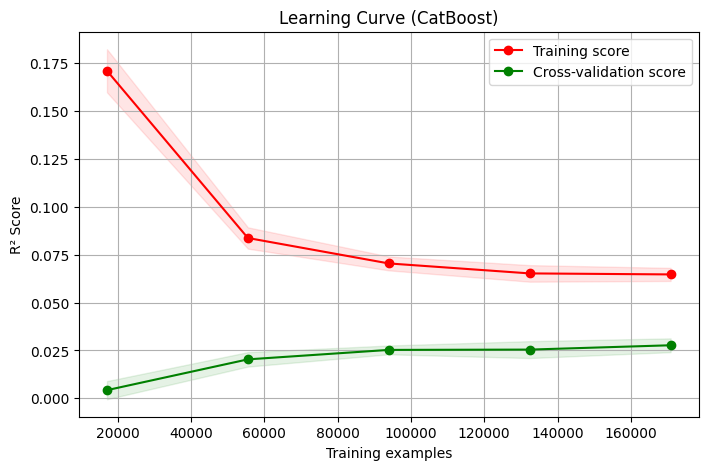


Performing Cross-Validation...
Cross-validated R² for CatBoost: 0.0277 (± 0.0036)


In [42]:
print("\n--- Step 4.A.2: Model Performance Comparison ---")
best_model_name_a = None
best_model_a = None

if 'model_performance_a' in locals() and model_performance_a:
    performance_df_a = pd.DataFrame(model_performance_a).T.sort_values(by='R2', ascending=False)
    print(performance_df_a)
    if not performance_df_a.empty:
        best_model_name_a = performance_df_a.index[0]
        best_model_a = trained_models.get(best_model_name_a)
        print(f"\nBest model (by R2): {best_model_name_a}")
    else: print("Cannot determine best model.")

    if best_model_a and best_model_name_a:
        print(f"\n--- Detailed Analysis for: {best_model_name_a} ---")
        # SHAP Dependence Plots
        # if best_model_name_a in shap_values_dict_a and best_model_name_a in shap_importance_dict_a:
        if best_model_name_a in locals() and best_model_name_a in shap_importance_dict_a:
            print(f'\n-- Top 20 features by SHAP Importance ({best_model_name_a}) ---')
            top_n = 20
            shap_imp_df = shap_importance_dict_a[best_model_name_a]
            if not shap_imp_df.empty:
                print(shap_imp_df.head(top_n))
            else: print("SHAP importance results missing.")

            print("Generating SHAP Dependence Plots...")
            shap_values_best = shap_values_dict_a[best_model_name_a]
            top_features_best = shap_importance_dict_a[best_model_name_a]['feature'].head(5).tolist()
            X_shap_df_context = pd.DataFrame(X_shap, columns=clean_names)
            for feat_name in top_features_best:
                try:
                    if feat_name in X_shap_df_context.columns:
                        shap.dependence_plot(feat_name, shap_values_best, X_shap_df_context, interaction_index='auto', show=False)
                        plt.title(f"SHAP Dependence: {feat_name} ({best_model_name_a})"); plt.tight_layout();plt.savefig(os.path.join(plot_dir, f'shap_dependence_{best_model_name_a}_{feat_name}.png'), dpi=150, bbox_inches='tight'); plt.show()
                except Exception as e: print(f"Error plotting Dependence for '{feat_name}': {e}")
        else: print("SHAP values missing for dependence plots.")
        # Learning Curve
        try:
            print("\nAnalyzing Learning Curve...")
            train_sizes, train_scores, test_scores = learning_curve(clone(best_model_a), X_train_trans, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), random_state=42)
            train_scores_mean, test_scores_mean = np.mean(train_scores, axis=1), np.mean(test_scores, axis=1)
            train_scores_std, test_scores_std = np.std(train_scores, axis=1), np.std(test_scores, axis=1)
            plt.figure(figsize=(8, 5))
            plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
            plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
            plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
            plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
            plt.title(f"Learning Curve ({best_model_name_a})"); plt.xlabel("Training examples"); plt.ylabel("R² Score")
            plt.legend(loc="best"); plt.grid(True); plt.savefig(os.path.join(plot_dir, f'learning_curve_{best_model_name_a}.png'), dpi=150, bbox_inches='tight'); plt.show()
        except Exception as e: print(f"Error during Learning Curve: {e}")
        # Cross-Validation
        try:
            print("\nPerforming Cross-Validation...")
            cv_scores = cross_val_score(clone(best_model_a), X_train_trans, y_train, cv=5, scoring='r2', n_jobs=-1)
            print(f"Cross-validated R² for {best_model_name_a}: {np.mean(cv_scores):.4f} (± {np.std(cv_scores):.4f})")
        except Exception as e: print(f"Error during Cross-Validation: {e}")
    else: print("Best model not determined.")
else: print("No models trained/evaluated. Skipping comparison.")

In [43]:
if 'model_performance_a' in locals() and model_performance_a:
  print('\n--- Model Performance Summary (Arrival Delay Prediction) ---')
  performance_df = pd.DataFrame(model_performance_a).T
  performance_df = performance_df.sort_values(by='R2', ascending=False)

  formmatted_performance_df = performance_df.copy()
  for col in ['MAE', 'RMSE', 'R2']:
    formmatted_performance_df[col] = formmatted_performance_df[col].map('{:.4f}'.format)
  print(formmatted_performance_df)

else:
  print("No model performance data available.")


--- Model Performance Summary (Arrival Delay Prediction) ---
                             MAE               RMSE                         R2
CatBoost                 48.5648            92.6805                     0.0323
Ensemble                 48.5520            92.6856                     0.0322
LightGBM                 48.5410            92.7390                     0.0311
XGBoost                  48.5388            92.7896                     0.0301
GradientBoosting         48.6778            92.8551                     0.0287
RandomForest             48.8049            93.1611                     0.0223
LinearRegression  979396346.2335  116093392544.0795  -1518311521840287488.0000


# 7: Integrated Analysis

## 7.C.1: Feature Importance vs. Network Centrality


--- Step 7: Starting Integrated Analysis ---

--- Step 5: Starting Integrated Analysis ---
Proceeding with integrated analysis.

--- C.1. Top SHAP Features (CatBoost) ---
['num__AIR_TIME', 'num__DISTANCE', 'num__AIRLINE_ARR_DELAY_MEAN', 'num__AVG_SPEED', 'num__DEST_ARR_DELAY_MEAN', 'num__ORIGIN_ARR_DELAY_MEAN', 'num__AIRLINE_DEP_DELAY_MEAN', 'num__ORIGIN_DEP_DELAY_MEAN', 'num__MONTH_cos', 'num__CRS_DEP_HOUR_cos', 'num__IS_ORIGIN_HUB', 'num__WEEKDAY_sin', 'num__DEST_DEP_DELAY_MEAN', 'num__SEASON', 'num__IS_DEST_HUB', 'num__hour', 'num__CRS_DEP_HOUR_sin', 'num__MONTH_sin', 'num__ORIGIN_Betweenness', 'num__ORIGIN_PageRank']

--- C.2. Top Airports (PageRank) ---
['DFW', 'ORD', 'ATL', 'CLT', 'DEN', 'IAH', 'BOS', 'MSP', 'DTW', 'EWR']

--- C.3. SHAP Importance of Network Features ---
                    feature  importance
22  num__ORIGIN_Betweenness      0.2857
21     num__ORIGIN_PageRank      0.2367
23       num__DEST_PageRank      0.1987
24    num__DEST_Betweenness      0.1970

Plotting S

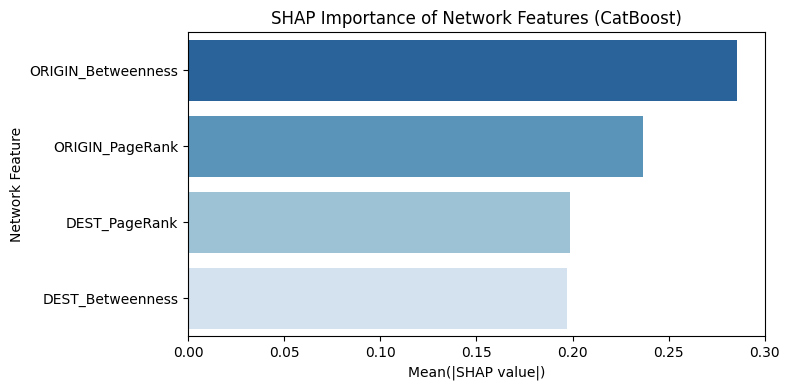

In [44]:
# Setup
print("\n--- Step 7: Starting Integrated Analysis ---")

if 'plot_dir' not in locals():
    plot_dir = "plot_outputs" # Default if not defined
    if not os.path.exists(plot_dir): os.makedirs(plot_dir)

print("\n--- Step 5: Starting Integrated Analysis ---")
analysis_possible = (
    'best_model_name_a' in locals() and best_model_name_a and
    best_model_name_a in shap_importance_dict_a and
    'network_results_b' in locals() and not network_results_b.empty and
    'preprocessor' in locals() and preprocessor and
    'clean_names' in locals() and clean_names
)

if not analysis_possible:
    print("Warning: Results missing. Cannot perform integrated analysis.")
else:
    print("Proceeding with integrated analysis.")
    # 1. Top SHAP Features (List)
    top_shap_features_c = shap_importance_dict_a[best_model_name_a]['feature'].head(20).tolist()
    print(f"\n--- C.1. Top SHAP Features ({best_model_name_a}) ---")
    print(top_shap_features_c)

    # 2. Top Network Airports (List)
    if 'Airport' in network_results_b.columns and 'PageRank' in network_results_b.columns:
        top_airports_pr_c = network_results_b.sort_values('PageRank', ascending=False)['Airport'].head(10).tolist()
        print("\n--- C.2. Top Airports (PageRank) ---")
        print(top_airports_pr_c)
    else:
        print("\n--- C.2. Top Airports: Network results missing required columns. ---")


    # 3. SHAP Importance of Network Features (DataFrame & Plot)
    print("\n--- C.3. SHAP Importance of Network Features ---")
    # Use the full feature names from 'clean_names' which might include prefixes
    network_feature_names = [f for f in clean_names if 'PageRank' in f or 'Betweenness' in f]

    if network_feature_names:
        # Extract importance for network features
        network_shap_importance = shap_importance_dict_a[best_model_name_a][
            shap_importance_dict_a[best_model_name_a]['feature'].isin(network_feature_names)
        ].copy() # Use copy to avoid SettingWithCopyWarning

        if not network_shap_importance.empty:
            print(network_shap_importance)

            # --- NEW: Plotting Network Feature Importance ---
            print("\nPlotting SHAP Importance of Network Features...")
            try:
                # Clean feature names for plotting
                network_shap_importance['feature_clean'] = network_shap_importance['feature'].str.replace('num__', '').str.replace('cat__', '').str.replace('remainder__','')
                network_shap_importance.sort_values('importance', ascending=False, inplace=True)

                plt.figure(figsize=(8, max(4, len(network_shap_importance) * 0.5))) # Adjust height based on number of features
                sns.barplot(x='importance', y='feature_clean', data=network_shap_importance, palette='Blues_r')
                plt.title(f'SHAP Importance of Network Features ({best_model_name_a})')
                plt.xlabel('Mean(|SHAP value|)')
                plt.ylabel('Network Feature')
                plt.tight_layout()
                # Save the plot
                plot_filename = os.path.join(plot_dir, f'shap_importance_network_features_{best_model_name_a}.png')
                plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
                print(f"Network feature importance plot saved to {plot_filename}")
                plt.show()

            except Exception as e:
                print(f"Error plotting network feature importance: {e}")
            # ----------------------------------------------

        else:
            print("Network features found in 'clean_names', but not in SHAP importance results (importance might be zero).")
    else:
        print("Could not find network-related features (PageRank/Betweenness) in the final feature list ('clean_names').")



## 7.C.2: Correlation Analysis (Airport SHAP vs PageRank)

In [45]:
if analysis_possible:
    print("\n--- C.2. Correlation: Airport SHAP vs PageRank ---")
    try:
        ohe_transformer, cat_feature_names_original, cat_transformer_tuple = None, [], None
        for t_tuple in preprocessor.transformers_:
             name, trans, features = t_tuple
             if isinstance(trans, OneHotEncoder) or name == 'cat':
                 ohe_transformer, cat_feature_names_original, cat_transformer_tuple = trans, features, t_tuple
                 break
        if ohe_transformer and cat_transformer_tuple and 'ORIGIN' in cat_feature_names_original and 'DEST' in cat_feature_names_original:
            ohe_feature_names_out = preprocessor.named_transformers_[cat_transformer_tuple[0]].get_feature_names_out(cat_feature_names_original)
            airport_shap_scores = {}
            shap_importance_indexed = shap_importance_dict_a[best_model_name_a].set_index('feature')
            for full_feat_name in ohe_feature_names_out:
                importance = shap_importance_indexed.loc[full_feat_name, 'importance'] if full_feat_name in shap_importance_indexed.index else 0
                if '_ORIGIN_' in full_feat_name: airport_code = full_feat_name.split('_ORIGIN_')[-1]
                elif '_DEST_' in full_feat_name: airport_code = full_feat_name.split('_DEST_')[-1]
                else: continue
                airport_shap_scores[airport_code] = airport_shap_scores.get(airport_code, {'origin': 0, 'dest': 0})
                if '_ORIGIN_' in full_feat_name: airport_shap_scores[airport_code]['origin'] += importance
                else: airport_shap_scores[airport_code]['dest'] += importance

            if airport_shap_scores:
                shap_agg = {airport: data['origin'] + data['dest'] for airport, data in airport_shap_scores.items()}
                shap_pr_df = pd.DataFrame.from_dict(shap_agg, orient='index', columns=['shap_importance_agg'])
                shap_pr_df.index.name = 'Airport'
                if 'Airport' in network_results_b.columns and 'PageRank' in network_results_b.columns:
                    merged_shap_pr = pd.merge(shap_pr_df, network_results_b[['Airport', 'PageRank']], on='Airport', how='inner')
                    if not merged_shap_pr.empty and len(merged_shap_pr) > 1:
                        correlation, p_value = spearmanr(merged_shap_pr['shap_importance_agg'], merged_shap_pr['PageRank'])
                        print(f"Spearman Correlation: rho={correlation:.3f}, p-value={p_value:.3f}")
                        plt.figure(figsize=(7, 5))
                        sns.scatterplot(data=merged_shap_pr, x='PageRank', y='shap_importance_agg')
                        sns.regplot(data=merged_shap_pr, x='PageRank', y='shap_importance_agg', scatter=False, color='red', line_kws={'linestyle':'--'})
                        plt.title('PageRank vs. Aggregated Airport SHAP'); plt.xlabel('PageRank'); plt.ylabel('Aggregated SHAP (Origin+Dest)')
                        plt.grid(True, linestyle=':'); plt.savefig(os.path.join(plot_dir, 'correlation_pagerank_vs_shap.png'), dpi=150, bbox_inches='tight'); plt.show()
                    else: print("Not enough common airports for correlation.")
                else: print("Network results missing columns.")
            else: print("Could not extract airport SHAP scores.")
        else: print("OHE/Airport features not found. Skipping correlation.")
    except Exception as e: print(f"Error during correlation: {e}")
else: print("Skipping Correlation Analysis.")


--- C.2. Correlation: Airport SHAP vs PageRank ---
Could not extract airport SHAP scores.


In [46]:
if 'network_results_b' in locals() and not network_results_b.empty:
    print(network_results_b.head())
    if 'PageRank' in network_results_b.columns and 'Airport' in network_results_b.columns:
      print(network_results_b.sort_values('PageRank', ascending=False).head(10)[['Airport', 'PageRank']])
    else: print("Network results missing required columns.")
    print('\n--- Top 10 Airports by Betweenness Centrality ---')
    if 'Betweenness' in network_results_b.columns and 'Airport' in network_results_b.columns:
      print(network_results_b.sort_values('Betweenness', ascending=False).head(10)[['Airport', 'Betweenness']])
    else: print("Required columns ('Airport', 'Betweenness') not in network_results_b.")
else: print("No network results available.")

  Airport  PageRank  Betweenness
0     DFW    0.0252       0.0336
2     ORD    0.0251       0.0382
3     ATL    0.0210       0.0344
4     CLT    0.0210       0.0196
1     DEN    0.0207       0.0381
   Airport  PageRank
0      DFW    0.0252
2      ORD    0.0251
3      ATL    0.0210
4      CLT    0.0210
1      DEN    0.0207
12     IAH    0.0195
13     BOS    0.0188
20     MSP    0.0185
17     DTW    0.0179
10     EWR    0.0179

--- Top 10 Airports by Betweenness Centrality ---
   Airport  Betweenness
2      ORD       0.0382
1      DEN       0.0381
3      ATL       0.0344
0      DFW       0.0336
5      LAS       0.0275
24     MDW       0.0202
4      CLT       0.0196
20     MSP       0.0190
12     IAH       0.0188
8      PHX       0.0183


## 7.C.3: Ablation Study


--- C.3. Feature Ablation Study --- 
Ablation: Base (778), Prop (1), Network (4) features identified.

Processing Ablation Group: Base (778 features)
  Training model...
  Finished: R2 = 0.0318

Processing Ablation Group: Base+Prop (779 features)
  Training model...
  Finished: R2 = 0.0314

Processing Ablation Group: Base+Network (782 features)
  Training model...
  Finished: R2 = 0.0325

Processing Ablation Group: All_Features (783 features)
  Training model...
  Finished: R2 = 0.0323

Ablation Study Results:
              Num_Features     MAE    RMSE     R2
Base+Network      782.0000 48.5685 92.6751 0.0325
All_Features      783.0000 48.5648 92.6805 0.0323
Base              778.0000 48.5938 92.7072 0.0318
Base+Prop         779.0000 48.5803 92.7276 0.0314


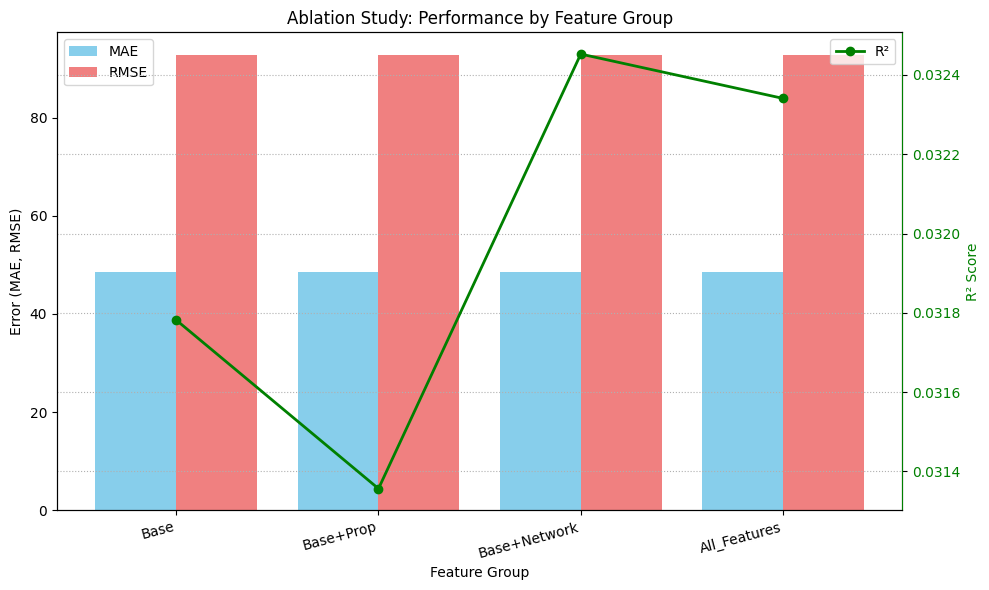

In [ ]:
if analysis_possible and 'best_model_a' in locals() and best_model_a:
    print("\n--- C.3. Feature Ablation Study --- ")
    prop_feature_name = next((name for name in clean_names if 'D_a_i_minus1' in name), None)
    propagation_features = [prop_feature_name] if prop_feature_name else []
    network_features_in_names = [f for f in clean_names if 'PageRank' in f or 'Betweenness' in f]
    base_features = [f for f in clean_names if f not in propagation_features and f not in network_features_in_names]
    print(f"Ablation: Base ({len(base_features)}), Prop ({len(propagation_features)}), Network ({len(network_features_in_names)}) features identified.")

    feature_groups = {}
    if base_features: feature_groups['Base'] = base_features
    if base_features and propagation_features: feature_groups['Base+Prop'] = list(set(base_features + propagation_features))
    if base_features and network_features_in_names: feature_groups['Base+Network'] = list(set(base_features + network_features_in_names))
    if clean_names: feature_groups['All_Features'] = clean_names

    ablation_results = {}
    base_model_for_ablation = clone(best_model_a)

    for group_name, features_in_group in feature_groups.items():
        print(f"\nProcessing Ablation Group: {group_name} ({len(features_in_group)} features)")
        if not features_in_group: continue
        try:
            feature_indices = [clean_names.index(f) for f in features_in_group]
            if not feature_indices: continue
            X_train_abl, X_test_abl = X_train_trans[:, feature_indices], X_test_trans[:, feature_indices]
            if X_train_abl.shape[1] == 0: continue
            print(f"  Training model...")
            model_abl = clone(base_model_for_ablation); model_abl.fit(X_train_abl, y_train)
            preds_abl = model_abl.predict(X_test_abl)
            ablation_results[group_name] = {
                'Num_Features': len(features_in_group),
                'MAE': mean_absolute_error(y_test, preds_abl),
                'RMSE': mean_squared_error(y_test, preds_abl, squared=False),
                'R2': r2_score(y_test, preds_abl)
            }
            print(f"  Finished: R2 = {ablation_results[group_name]['R2']:.4f}")
        except Exception as e: print(f"  Error processing group '{group_name}': {e}")

    if ablation_results:
        ablation_df = pd.DataFrame(ablation_results).T.sort_values(by='R2', ascending=False)
        print("\nAblation Study Results:")
        print(ablation_df)
        try:
            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax2 = ax1.twinx()
            plot_data = ablation_df.reset_index().rename(columns={'index': 'Feature Group'}).sort_values('Num_Features')
            x_pos = np.arange(len(plot_data))
            ax1.bar(x_pos - 0.2, plot_data['MAE'], 0.4, label='MAE', color='skyblue')
            ax1.bar(x_pos + 0.2, plot_data['RMSE'], 0.4, label='RMSE', color='lightcoral')
            ax2.plot(x_pos, plot_data['R2'], label='R²', color='green', marker='o', linewidth=2)
            ax1.set_ylabel('Error (MAE, RMSE)'); ax2.set_ylabel('R² Score', color='green')
            ax1.set_xlabel('Feature Group'); ax1.set_xticks(x_pos); ax1.set_xticklabels(plot_data['Feature Group'], rotation=15, ha='right')
            ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
            ax2.tick_params(axis='y', labelcolor='green'); ax2.spines['right'].set_color('green')
            plt.title('Ablation Study: Performance by Feature Group'); plt.grid(True, axis='y', linestyle=':')
            fig.tight_layout(); plt.savefig(os.path.join(plot_dir, 'ablation_study_performance.png'), dpi=150, bbox_inches='tight') ; plt.show()
        except Exception as e: print(f"Error visualizing ablation: {e}")
    else: print("No results from Ablation Study.")
else: print("Skipping Ablation Study.")

In [48]:
if 'ablation_df' in locals() and not ablation_df.empty and 'Base' in ablation_df.index:
    print("\n--- Ablation Study Performance Change (vs. Base Model) ---")

    base_results = ablation_df.loc['Base']

    # Calculate percentage changes
    performance_changes = ablation_df.copy()
    performance_changes["MAE_Change (%)"] = ((base_results['MAE'] - ablation_df['MAE']) / base_results['MAE'] * 100).map('{:.2f}'.format)
    performance_changes["RMSE_Change (%)"] = ((base_results['RMSE'] - ablation_df['RMSE']) / base_results['RMSE'] * 100).map('{:.2f}'.format)
    performance_changes["R2_Change (%)"] = ((base_results['R2'] - ablation_df['R2']) / base_results['R2'] * 100).map('{:.2f}'.format)

    print(performance_changes[['MAE_Change (%)', 'RMSE_Change (%)', 'R2_Change (%)']].drop('Base', errors='ignore'))


--- Ablation Study Performance Change (vs. Base Model) ---
             MAE_Change (%) RMSE_Change (%) R2_Change (%)
Base+Network           0.05            0.03         -2.11
All_Features           0.06            0.03         -1.76
Base+Prop              0.03           -0.02          1.34


In [49]:
# SHAP Analysis for Flights Involving Top Hubs
if analysis_possible and 'best_model_a' in locals() and best_model_a:
    print("\n--- C.6. SHAP Analysis for Top Hubs --- ")
    top_pr_airports_detail = []
    if 'Airport' in network_results_b.columns: top_pr_airports_detail = network_results_b.sort_values('PageRank', ascending=False)['Airport'].head(3).tolist()
    if not top_pr_airports_detail: print("Top hubs list not available.")

    if best_model_name_a in shap_values_dict_a and top_pr_airports_detail and 'X_test' in locals():
        try:
            explainer_detail = None
            if best_model_name_a in ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']:
                explainer_detail = shap.TreeExplainer(best_model_a)
            elif best_model_name_a == 'LinearRegression':
                background_data = shap.sample(X_train_trans, 100)
                explainer_detail = shap.LinearExplainer(best_model_a, background_data)

            if explainer_detail:
                test_index_map = {original_idx: transformed_idx for transformed_idx, original_idx in enumerate(X_test.index)}
                for airport in top_pr_airports_detail:
                    print(f"\n--- Analyzing SHAP for Airport: {airport} ---")
                    origin_indices = [test_index_map[idx] for idx in X_test[X_test['ORIGIN'] == airport].index if idx in test_index_map]
                    dest_indices = [test_index_map[idx] for idx in X_test[X_test['DEST'] == airport].index if idx in test_index_map]

                    if origin_indices:
                        X_subset = X_test_trans[origin_indices]
                        if X_subset.shape[0] > 0:
                            shap_values_sub = explainer_detail.shap_values(X_subset)
                            if isinstance(shap_values_sub, list): shap_values_sub = shap_values_sub[0]
                            if isinstance(shap_values_sub, np.ndarray):
                                shap_df = pd.DataFrame(np.abs(shap_values_sub).mean(axis=0), index=clean_names, columns=['mean_abs_shap'])
                                print(f"Top 5 Features (Originating from {airport}):\n{shap_df.sort_values('mean_abs_shap', ascending=False).head(5)}")
                    else: print(f"No originating flights for {airport} in test sample.")

                    if dest_indices:
                        X_subset = X_test_trans[dest_indices]
                        if X_subset.shape[0] > 0:
                            shap_values_sub = explainer_detail.shap_values(X_subset)
                            if isinstance(shap_values_sub, list): shap_values_sub = shap_values_sub[0]
                            if isinstance(shap_values_sub, np.ndarray):
                                shap_df = pd.DataFrame(np.abs(shap_values_sub).mean(axis=0), index=clean_names, columns=['mean_abs_shap'])
                                print(f"\nTop 5 Features (Arriving at {airport}):\n{shap_df.sort_values('mean_abs_shap', ascending=False).head(5)}")
                    else: print(f"No arriving flights for {airport} in test sample.")
            else: print(f"SHAP explainer not available for {best_model_name_a}.")
        except Exception as e: print(f"Error during specific airport SHAP: {e}")
    else: print(f"Skipping specific airport SHAP: Requirements not met.")
else: print("Skipping specific airport SHAP.")


--- C.6. SHAP Analysis for Top Hubs --- 

--- Analyzing SHAP for Airport: DFW ---
Top 5 Features (Originating from DFW):
                             mean_abs_shap
num__AIR_TIME                       5.5782
num__DISTANCE                       4.6752
num__AIRLINE_ARR_DELAY_MEAN         3.9430
num__AVG_SPEED                      3.0016
num__DEST_ARR_DELAY_MEAN            2.6285

Top 5 Features (Arriving at DFW):
                             mean_abs_shap
num__DEST_ARR_DELAY_MEAN            6.2396
num__AIR_TIME                       5.6892
num__AVG_SPEED                      4.8630
num__DISTANCE                       4.5888
num__AIRLINE_ARR_DELAY_MEAN         4.4117

--- Analyzing SHAP for Airport: ORD ---
Top 5 Features (Originating from ORD):
                             mean_abs_shap
num__AIR_TIME                       6.6552
num__DISTANCE                       5.6585
num__AIRLINE_ARR_DELAY_MEAN         3.7831
num__DEST_ARR_DELAY_MEAN            2.7677
num__AVG_SPEED                  

# Summary

* **Data Leakage:** Correction likely resulted in lower but more realistic model performance.
* **Feature Importance (A):** SHAP on corrected models reveals importance of time, means, network centrality, and `D_a_i_minus1` (proxy).
* **Network Centrality (B):** Hubs identified. SIR/Tracing show propagation patterns, compared against centrality for validation.
* **Integrated Importance (C):** Ablation Study quantifies value of adding Network vs. Propagation (`D_a_i_minus1`) info. Final SHAP shows relative importance of all feature types. Correlation relates network structure (PageRank) to model feature importance.
* **Limitations:** Propagation analysis limited by missing `TAIL_NUM`. `D_a_i_minus1` based on `ROUTE_KEY` is used as the available proxy.